## l_______________________________________________________________________

### Feriados

Janeiro
01	TER	Ano-Novo
Abril
19	SEX	Sexta-feira Santa
21	DOM	Tiradentes
21	DOM	Páscoa

In [1]:
hollydays=['2018-12-25', '2018-12-31','2019-01-01', '2019-03-04','2019-03-05','2019-03-06']
for i in ['01','19','21']:
    hollydays.append('2019-04-'+i)
#hollydays = [pd.Timestamp(i) for i in hollydays]

In [2]:
hollydays

['2018-12-25',
 '2018-12-31',
 '2019-01-01',
 '2019-03-04',
 '2019-03-05',
 '2019-03-06',
 '2019-04-01',
 '2019-04-19',
 '2019-04-21']

In [3]:
def drop_dates(df, dates, inplace=False):
    """
        inputs:
            df -> a dataframe indexed by dates
            dates -> a list of str '%YYYY-MM-DD' dates
            inplace -> similar to pd.drop inplace parameter
        returns:
            df where dates are dropped if inplace is False
            None if inplace is True (similar to pd.drop)
    """
    to_drop_dates = list()
    for d in dates:
        to_drop_dates = to_drop_dates + list(df[d].index)
    dfo = df.drop(to_drop_dates,axis=0, inplace=inplace)
    return dfo

## l_______________________________________________________________________

In [4]:
import pickle
processados = pickle.load(open('../pickles/all/processados.pkl','rb'))

FileNotFoundError: [Errno 2] No such file or directory: '../pickles/all/processados.pkl'

In [5]:
erros = pickle.load(open('../pickles/all/erros.pkl','rb'))

FileNotFoundError: [Errno 2] No such file or directory: '../pickles/all/erros.pkl'

## l_______________________________________________________________________

In [6]:
import json
import os
import pandas as pd
from genData import load_model

import json
import os
import pandas as pd
from genData import load_model
import re
import numpy as np
import pickle

from importlib import reload
import mainlib
reload(mainlib)
import A_base as ab
reload(ab)
from  mainlib import fasorial, lista, sdict, mm, mm_sep


import collections
import of_proc
reload(of_proc)
from of_proc import *

Using TensorFlow backend.


# Informações

In [7]:
def read_info(path = '../info/info.json'):
    global PATH, OUTPUT_PATH, PROCESSED_PATH, PERFIS_PATH, HORARIOS_PATH, PATH_MM, PATH_FAS, \
    DEG, MOR, PER, FAS, OUTPUT_HEADER,FAS_CONCAT, MM_CONCAT, PICKLES_CONCAT, OUT_INDEX
    with open(path) as f:
        info = json.load(f)
        PATH = info['paths']['fasoriais']['input']
        OUTPUT_PATH = info['paths']['fasoriais']['output']
        PROCESSED_PATH = info['paths']['fasoriais']['processed']
        PERFIS_PATH = info['paths']['perfis']['perfis']
        HORARIOS_PATH = info['paths']['perfis']['horarios']
        PATH_MM = info['paths']['mm']['input']
        PATH_FAS = info['paths']['fasoriais']['input']
        DEG = info['paths']['nn_models']['degrau']
        MOR = info['paths']['nn_models']['morro']
        PER = info['paths']['nn_models']['perfil']
        FAS = info['paths']['nn_models']['fasorial']
        FAS_CONCAT =  info['paths']['concat']['fas']
        MM_CONCAT =  info['paths']['concat']['mm'] 
        PICKLES_CONCAT=  info['paths']['concat']['pickles']        
        OUTPUT_HEADER = info['output']['header']
        OUT_INDEX = info['output']['header']

In [8]:
read_info()

In [9]:
OUT_CONCAT = '../outputs/concat/'
OUT = '../outputs/all/'

In [10]:
#preguiça -- arrumar
out_index = OUT_INDEX

### Carregar modelos neurais

# Coleções principais

#### Lista principal

In [11]:
global LISTA_CAD

#### Modelos neurais

In [12]:
global PERFIL, DEGRAU, MORRO, NN_FAS
PERFIL, DEGRAU, MORRO, NN_FAS = load_models(PER, DEG, MOR, FAS)

Instructions for updating:
Colocations handled automatically by placer.


#### Arquivos

In [13]:
global files_fas, files_mm

#### Perfis e horários

In [14]:
global HORARIOS, PERFIS, ATIVS, DPERFIS, DPERFIS_NORMAL, DPERFIS_TROCA

#### Estruturas auxiliares

In [15]:
global dim, dmi, df_fas, dfiles_mm, dfiles_fas_troca, dfiles_mm_troca, dfiles_fas_normal, dfiles_mm_normal
global o_i_normal, o_i_troca, o_instas, list_i_normal, list_i_troca, list_intas

## Lista de medidores e lista por horários

In [16]:
LISTA_CAD = get_list()

In [17]:
HORARIOS, PERFIS, ATIVS = get_horario_info()

### Dicionários e listas

In [18]:
dim, dmi = dicts(LISTA_CAD)

In [19]:
#gls i_normal -> instalações normal
# i_troca -> instalações com troca
#o_i_normal -> ordenado instalações normal
o_i_normal = collections.OrderedDict(sorted(LISTA_CAD.get_users(index = 'instalacao', troca=0,tipo='dictionary').items()))
o_i_troca = collections.OrderedDict(sorted(LISTA_CAD.get_users(index = 'instalacao', troca=1,tipo='dictionary').items()))
o_instas =  collections.OrderedDict(sorted({**o_i_normal, **o_i_troca}.items()))

##### Dicionário com os horário de funcionamento de cada cliente

In [20]:
DPERFIS = sdict()
for i in PERFIS.index:
    j = PERFIS.loc[i,'Ramo de Atividade']
    if HORARIOS.index.contains(j):
        DPERFIS[i] = list(HORARIOS.loc[j,:])
    else:
        DPERFIS[i] = list(HORARIOS.iloc[0,:])

DPERFIS_NORMAL={}
for i in DPERFIS:
    if i in o_i_normal:
        DPERFIS_NORMAL[i] = o_i_normal[i]

DPERFIS_TROCA={}
for i in DPERFIS:
    if i in o_i_troca:
        DPERFIS_TROCA[i] = o_i_troca[i]

In [21]:
dfiles_fas, nf_fas=get_files_3(list(o_i_normal.keys()), dim,  PATH_FAS)
dfiles_mm, nf_mm = get_files_3(list(o_i_normal.keys()),dim , PATH_MM)

In [22]:
dfiles_fas2 = deslistar(dfiles_fas)
dfiles_mm2 = deslistar(dfiles_mm)

In [23]:
dfiles_fas_concat, nf_fas_concat = get_files_2( list(o_i_troca.keys()), FAS_CONCAT)
dfiles_mm_concat, nf_mm_concat = get_files_2( list(o_i_troca.keys()), MM_CONCAT)

## l_______________________________________________________________________

## l_______________________________________________________________________

In [24]:
dfiles_fas_concat = get_files_troca(dfiles_fas_concat)

In [25]:
dfiles_mm_concat= get_files_troca(dfiles_mm_concat)

In [26]:
odf_concat = collections.OrderedDict(sorted(dfiles_fas_concat.items()))

In [27]:
odmm_concat = collections.OrderedDict(sorted(dfiles_mm_concat.items()))

## l_______________________________________________________________________

#### Nova função de corrente zero

In [28]:
def new_corrent_zero(grid):
    pAmp = 20
    relacao = 400/5
    rdias = 0
    rminutos = 0
    severidade_regra = 0 #certeza de que nao tem nada errado
    cdata = -1
    
    corrente_referencia = pAmp/relacao
    rise = {}
    rise['IA'] = (grid['IA'] >= corrente_referencia/3).any()
    rise['IB'] = (grid['IB'] >= corrente_referencia/3).any()
    rise['IC'] = (grid['IC'] >= corrente_referencia/3).any()

#     print("Corrente de referencia:", corrente_referencia)
#     print("iA tem valores maiores que referencia/3: ", iA_levanta)
#     print("iB tem valores maiores que referencia/3: ", iB_levanta)
#     print("iC tem valores maiores que referencia/3: ", iC_levanta)

    for index, row in grid.iterrows():
        data = index.date()
        datastr = index.strftime('%Y-%m-%d')
        hora = index.time().hour
        correntes={}
        correntes['IA'] = float(row['IA'])*relacao
        correntes['IB'] = float(row['IB'])*relacao
        correntes['IC'] = float(row['IC'])*relacao
        zeros = {'IA':0, 'IB':0, 'IC':0}
        for i in ['IA', 'IB', 'IC']:
            if (cdata == -1 or cdata != data):
                #feriado = verificaFeriado(datastr, feriados)
                #print("data: ", datastr, feriado)
                if (cdata != -1):
                    ocorrencias = (horas*4)*0.7 #70%do tempo
                    #print(cdata,"Ref Ocorrencias:",ocorrencias,"IA",zeroiA,naozeroiA,"IB",zeroiB,naozeroiB,"IC",zeroiC,naozeroiC)
                    #print(zeros[i])
                    #continue
                    if (zeros[i] >= ocorrencias): # and naozeroiA == 0):
                        rdias +=1
                        rminutos +=(zeros[i]*15)                  
                #novo dia, começa a contar novamente
                cdata = data
                for i in correntes:
                    correntes[i]=0
                for i in zeros:
                    zeros[i] = 0

            horas= int(grid[datastr][i].resample('H').count().resample('D').count())
            #hf,horas = horarioFuncionamento(hora, dia, semanai, semanaf, sabadoi, sabadof, domingoi, domingof)
            #print(hf,cdata,hora,dia,iA,iB,iC)
            if (correntes[i] == 0):
                severidade_regra = 1
                if (correntes['IA']+correntes['IB']+correntes['IC'] >= pAmp):
                    #condição C = corrente zero e a soma das outras duas é maior ou igual a pAmp
                    zeros[i] +=1
                elif (not rise[i]):
                    #condição A = corrente zero na fase A sendo que a fase A nunca ultrapassa 1/3 de pAmp
                    zeros[i] +=1

    #so para ajustar severidade_regra
    if (rdias >= 10): # nao importa rminutos
        severidade_regra = 2
        
    return rdias, rminutos, severidade_regra

In [29]:
#Nova implementação para contabilização de corrente zero
#Novidades:
# a) Lista de feriados
# b) Regra de contabilização nao se restringe à corrente ser zero apenas dentro do horário de funcionamento e do feriado

import datetime
from datetime import datetime
from datetime import time
from dateutil import parser

# def parseDate(strdate):
#     #format ddmmyyyyhhMMss
#     try:
#         result = parser.parse(strdate[0:2]+"/"+strdate[3:5]+"/"+strdate[6:10]+" "+strdate[11:13]+":"+strdate[14:16]+":00", dayfirst=True)
#     except ValueError:
#         #print (strdate)
#         result = parser.parse("01/01/1980 00:00:00", dayfirst=True)
#     return result
        
def horarioFuncionamento(hora, dia, semanai=8, semanaf=18, sabadoi=8, sabadof=18, domingoi=8, domingof=18):
    # veja que estou tratando String e tirei as acentuações do arquivo CSV
    # se voce tiver jeito melhor de fazer pode mudar
    if (dia == "Sabado"):
        horas = sabadof - sabadoi
        return (hora >= sabadoi and hora < sabadof), horas
    if (dia == "Domingo"):
        horas = domingof - domingoi
        return (hora >= domingoi and hora < domingof), horas
    else:
        horas = semanaf - semanai
        return (hora >= semanai and hora < semanaf), horas
    
def verificaFeriado(datastr, feriados):
    return (feriados['Feriados'] == datastr).any()
    
def NEWcorrenteZero(grid, feriados, pAmp, relacao, semanai=8, semanaf=18, sabadoi=8, sabadof=18, domingoi=8, domingof=18):
    rdias = 0
    rminutos = 0
    severidade_regra = 0 #certeza de que nao tem nada errado
    cdata = -1
    
    corrente_referencia = pAmp/relacao
    IA_levanta = (grid['IA'] >= corrente_referencia/3).any()
    IB_levanta = (grid['IB'] >= corrente_referencia/3).any()
    IC_levanta = (grid['IC'] >= corrente_referencia/3).any()
    za, zb, zc = [], [], []
    print("Corrente de referencia:", corrente_referencia)
    print("IA tem valores maiores que referencia/3: ", IA_levanta)
    print("IB tem valores maiores que referencia/3: ", IB_levanta)
    print("IC tem valores maiores que referencia/3: ", IC_levanta)
    for index, row in grid.iterrows():
        datetime = parseDate(row['data'])
        data = datetime.date()
        datastr = datetime.strftime("%d/%m/%Y")
        hora = datetime.time().hour
        dia = row['Dia']
        IA = float(row['IA'])*relacao
        IB = float(row['IB'])*relacao
        IC = float(row['IC'])*relacao
        naozeroIA, naozeroIB, naozeroIC = 0,0,0
        if (cdata == -1 or cdata != data):
            feriado = verificaFeriado(datastr, feriados)
            #print("data: ", datastr, feriado)
            if (cdata != -1):
                ocorrencias = (horas*4)*0.7 #70%do tempo
                print(cdata,"Ref Ocorrencias:",ocorrencias,"IA",zeroIA,"IB",zeroIB,"IC",zeroIC)
                za.append(zeroIA)
                zb.append(zeroIB)
                zc.append(zeroIC)
                if (zeroIA >= ocorrencias): # and naozeroIA == 0):
                    rdias +=1
                    rminutos +=(zeroIA*15)
                else:
                    if (zeroIB >= ocorrencias): # and naozeroIB == 0):
                        rdias +=1
                        rminutos +=(zeroIB*15)
                    else:
                        if (zeroIC >= ocorrencias): # and naozeroIC == 0):
                            rdias +=1
                            rminutos +=(zeroIC*15)
            #novo dia, começa a contar novamente
            cdata = data
            zeroIA, zeroIB, zeroIC = 0,0,0
            naozeroIA, naozeroIB, naozeroIC = 0,0,0
                   
        hf,horas = horarioFuncionamento(hora, dia, semanai, semanaf, sabadoi, sabadof, domingoi, domingof)
        #print(hf,cdata,hora,dia,IA,IB,IC)
        
        if (hf and not feriado):
            if (IA == 0):
                severidade_regra = 1
                if (IA+IB+IC >= pAmp):
                    #condição C = corrente zero e a soma das outras duas é maior ou igual a pAmp
                    zeroIA +=1
                else:
                    if (not IA_levanta):
                        #condição A = corrente zero na fase A sendo que a fase A nunca ultrapassa 1/3 de pAmp
                        zeroIA +=1
            else:
                naozeroIA +=1
            if (IB == 0):
                severidade_regra = 1
                if (IA+IB+IC >= pAmp):
                    #condição C = corrente zero e a soma das outras duas é maior ou igual a pAmp
                    zeroIB +=1
                else:
                    if (not IB_levanta):
                        #condição A = corrente zero na fase A sendo que a fase A nunca ultrapassa 1/3 de pAmp
                        zeroIB +=1
            else:
                naozeroIB +=1
            if (IC == 0):
                severidade_regra = 1
                if (IA+IB+IC >= pAmp):
                    #condição C = corrente zero e a soma das outras duas é maior ou igual a pAmp
                    zeroIC +=1
                else:
                    if (not IC_levanta):
                        #condição A = corrente zero na fase A sendo que a fase A nunca ultrapassa 1/3 de pAmp
                        zeroIC +=1
            else:
                naozeroIC +=1

    #so para ajustar severidade_regra
    if (rdias >= 10): # nao importa rminutos
        severidade_regra = 2
        
    return rdias, rminutos, severidade_regra

In [30]:
#teste
file = 'from_w/BTI410315485-fasor_08552562_20190711_153409.csv'
grid=pd.read_csv(file,delimiter=';').astype('object')
file = 'from_w/feriados.csv'
feriados=pd.read_csv(file,delimiter=';').astype('object')
pAmp = 20
relacao = 400/5 # Observacao: cliente BT2A a relação é 1/1

#dias, minutos, severidade_regra = NEWcorrenteZero(grid, feriados, pAmp, relacao, 8, 18, 8, 18, 8, 18)
#print ("Dias com corrente zero em horario de funcionamento:",dias, " --- Minutos:", minutos, " (", severidade_regra, ")")

In [31]:
def parseDate(strdate):
    #format ddmmyyyyhhMMss
    try:
        result = parser.parse(strdate[0:2]+"/"+strdate[3:5]+"/"+strdate[6:10]+" "+strdate[11:13]+":"+strdate[14:16]+":00", dayfirst=True)
    except ValueError:
        #print (strdate)
        result = parser.parse("01/01/1980 00:00:00", dayfirst=True)
    return result

## l_______________________________________________________________________

## Testes

## l-----------------------------------------------------------------------------------------------

## Corrente zero
##### Comparar resultado da nova função de corrente zero acima e a que fiz em pandas

## l-----------------------------------------------------------------------------------------------

In [109]:
import mainlib
reload(mainlib)
from mainlib import fasorial, infos

hours = infos().hours
hollydays = infos().hollydays
ddays = infos().ddays



## Funções

In [110]:
def proc_months(fas,less=False):
    for y in fas.months:
        for m in fas.months[y]:
            if less:
                fas.months[y][m].proc_fasorial_less()
            else:
                fas.months[y][m].proc_fasorial()

In [358]:
def build_fas(ex1, proc=True, **kwargs):
    if ex1 in dfiles_fas_concat.keys():
        print('troca')
        file1 = dfiles_fas_concat[ex1]
        ddays=o_i_troca[ex1]
        path = FAS_CONCAT
        f1 = fasorial(name=ex1)
        f1.read_fasorial(os.path.join(path,file1), dtype=None)
    elif ex1 in dfiles_fas.keys():
        print('normal')
        file1 = dfiles_fas[ex1] 
        ddays=o_i_normal[ex1]
        path = PATH_FAS       
        f1 = fasorial(name=ex1)
        f1.read_fasorial(os.path.join(path,file1[0]), dtype=None)
    
    
    f1.split_months(ddays=ddays)
    if proc:
        proc_months(f1, **kwargs)
    return f1

In [112]:
def proc2m(f1, proc=False):
    ld = sdict()
    for y in f1.months:
        for m in f1.months[y]:
            month = f1.months[y][m].df.copy()
            if proc:
                month = proc1m(month)
            ld[m] = month
    return ld

In [113]:
def proc1m(m):
    m.reset_index(inplace=True, drop=False)
    m['Dia']= m['data'].apply(lambda x: x.weekday()).map(said)
    m['data'] =pd.to_datetime(m['data'])
    m['data']= m['data'].apply(lambda x: x.strftime('%d/%m/%Y %H:%M'))
    return m



##  BTI413195196

### Variáveis

In [143]:
ex1='BTI413195196'

In [144]:
dias = {
    "Segunda":0,
    "Terca":1,
    "Quarta":2,
    "Quinta":3,
    "Sexta":4,
    "Sabado":5,
    "Domingo":6
    
}
said = {v:k for k,v in dias.items()}

In [145]:
hours = ['8:00', '18:00', '8:00', '18:00', '8:00', '18:00', '0:00', '0:00']

In [146]:
#0-> segunda
#6 -> domingo
#7 feriado
hours2 = {
    0:('8:00', '18:00'),
    1:('8:00', '18:00'),
    2:('8:00', '18:00'),
    3:('8:00', '18:00'),
    4:('8:00', '18:00'),
    5:('8:00', '18:00'),
    6:('8:00', '18:00'),
    7:('0:00', '0:00'),
}

In [316]:
hollydays = [
'2019-03-02',
'2019-03-03',
 '2019-03-04',
 '2019-03-05',
 '2019-03-06']

In [147]:
f1 = build_fas(ex1)
months = proc2m(f1)
months_proc = proc2m(f1, proc=True)

troca


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/index

## l_______________________________________________________________________

## Casos de controle 29072019

In [88]:
cc=['BT2A413509589', 'BT2A413504172', 'BTI412523996', 'BTI414723853', 'BTI413195196', 'BTI412954251', 'BTI411387957']

In [149]:
c01='BTI413195196' # Ok

BT2A413504172
<p> Não deve contabilizar volume expressivo de corrente zero. Igreja BT200Amp com cargas razoavelmente constantes nas fases B e C. Na fase A a carga só aparece no período do "culto".
Fora disso, fica 100% capacitiva às vezes e aparece pequena potencia negativa. </p>

In [312]:
c02 = 'BT2A413504172' 

BT2A413509589
<p>
Não deve contabilizar volume expressivo de corrente zero. A corrente zero da fase B está presente somente com correntes muito pequenas nas fases A e C. Quando a corrente A sobe, a B também sobe.
</p>

In [323]:
c03='BT2A413509589'

In [398]:
fc0 = build_fas(c01)
months = proc2m(fc0)
months_proc = proc2m(fc0, proc=True)

troca


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/index

## l_______________________________________________________________________

### Orig

In [325]:
results_proc = sdict()
for i in months_proc:
        results_proc[i] = NEWcorrenteZero(months_proc[i], feriados, pAmp, relacao, 8, 18, 8, 18, 8, 18)

Corrente de referencia: 0.25
IA tem valores maiores que referencia/3:  True
IB tem valores maiores que referencia/3:  True
IC tem valores maiores que referencia/3:  True
2018-12-17 Ref Ocorrencias: 28.0 IA 0 IB 12 IC 0
2018-12-18 Ref Ocorrencias: 28.0 IA 0 IB 12 IC 0
2018-12-19 Ref Ocorrencias: 28.0 IA 0 IB 12 IC 0
2018-12-20 Ref Ocorrencias: 28.0 IA 0 IB 11 IC 0
2018-12-21 Ref Ocorrencias: 28.0 IA 0 IB 11 IC 0
2018-12-22 Ref Ocorrencias: 28.0 IA 0 IB 10 IC 0
2018-12-23 Ref Ocorrencias: 28.0 IA 0 IB 12 IC 0
2018-12-24 Ref Ocorrencias: 28.0 IA 0 IB 17 IC 0
2018-12-25 Ref Ocorrencias: 28.0 IA 0 IB 13 IC 0
2018-12-26 Ref Ocorrencias: 28.0 IA 0 IB 12 IC 0
2018-12-27 Ref Ocorrencias: 28.0 IA 0 IB 9 IC 0
2018-12-28 Ref Ocorrencias: 28.0 IA 0 IB 15 IC 0
2018-12-29 Ref Ocorrencias: 28.0 IA 0 IB 8 IC 0
2018-12-30 Ref Ocorrencias: 28.0 IA 0 IB 5 IC 0
2018-12-31 Ref Ocorrencias: 28.0 IA 0 IB 16 IC 0
2019-01-01 Ref Ocorrencias: 28.0 IA 0 IB 10 IC 0
2019-01-02 Ref Ocorrencias: 28.0 IA 0 IB 9 IC 0
2

### Meu

In [404]:
reload(mainlib)
from mainlib import fasorial
f=fasorial()
results = sdict()
for i in months:
    print('-----------------')
    results[i] = ult_corrente_zero(hours2,hollydays,months[i])

-----------------
1--------------------
15--------------------


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

2--------------------


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


2--------------------
4--------------------
-----------------
1--------------------
15--------------------


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/ubu

2--------------------


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


2--------------------
4--------------------
-----------------
1--------------------
15--------------------


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/ubu

2--------------------


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


KeyboardInterrupt: 

### Meu com crop

In [327]:
reload(mainlib)
from mainlib import fasorial
f=fasorial()
results2 = sdict()
for i in months:
    results2[i] = ult_corrente_zero(hours2,hollydays,months[i].loc[:months[i].resample('D').count().index[-1].date(), :])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

### Resultados

In [328]:
print(results_proc)
print(results)
print(results2)

{1: (0, 0, 1), 2: (0, 0, 1), 3: (0, 0, 1), 4: (0, 0, 1)}
{1: (0, 0), 2: (0, 0), 3: (0, 0), 4: (0, 0)}
{1: (0, 0), 2: (0, 0), 3: (0, 0), 4: (0, 0)}


## l_______________________________________________________________________

In [329]:
janp = months_proc[4] 
jan = months[4]

In [330]:
ori = NEWcorrenteZero(janp, feriados, pAmp, relacao, 8, 18, 8, 18, 8, 18)
ori

Corrente de referencia: 0.25
IA tem valores maiores que referencia/3:  True
IB tem valores maiores que referencia/3:  True
IC tem valores maiores que referencia/3:  True
2019-03-13 Ref Ocorrencias: 28.0 IA 0 IB 10 IC 0
2019-03-14 Ref Ocorrencias: 28.0 IA 0 IB 15 IC 0
2019-03-15 Ref Ocorrencias: 28.0 IA 0 IB 12 IC 0
2019-03-16 Ref Ocorrencias: 28.0 IA 0 IB 12 IC 0
2019-03-17 Ref Ocorrencias: 28.0 IA 0 IB 9 IC 0
2019-03-18 Ref Ocorrencias: 28.0 IA 0 IB 12 IC 0
2019-03-19 Ref Ocorrencias: 28.0 IA 0 IB 9 IC 0
2019-03-20 Ref Ocorrencias: 28.0 IA 0 IB 10 IC 0
2019-03-21 Ref Ocorrencias: 28.0 IA 0 IB 7 IC 0
2019-03-22 Ref Ocorrencias: 28.0 IA 0 IB 11 IC 0
2019-03-23 Ref Ocorrencias: 28.0 IA 0 IB 14 IC 0
2019-03-24 Ref Ocorrencias: 28.0 IA 0 IB 15 IC 0
2019-03-25 Ref Ocorrencias: 28.0 IA 0 IB 15 IC 0
2019-03-26 Ref Ocorrencias: 28.0 IA 0 IB 17 IC 0
2019-03-27 Ref Ocorrencias: 28.0 IA 0 IB 15 IC 0
2019-03-28 Ref Ocorrencias: 28.0 IA 0 IB 13 IC 0
2019-03-29 Ref Ocorrencias: 28.0 IA 0 IB 10 IC 0


(0, 0, 1)

In [331]:
ori

(0, 0, 1)

In [268]:
jj = jan.loc[:jan.resample('D').count().index[-1].date(), :]

In [274]:
meu = ult_corrente_zero(hours2, hollydays, jan)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [275]:
meu

(23, 13425)

In [204]:
meu2

(20, 11985)

## l_______________________________________________________________________

  'BTI412954251' Deve acusar tensão zero

In [309]:
t02='BTI412954251'
fc0 = build_fas(t02)
proc_fas(fc0, ddays, NN_FAS )

normal


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/index

{'name': 'noname',
 'empty_values': {'IA': 0,
  'IB': 0,
  'IC': 0,
  'AIA': 0,
  'AIB': 0,
  'AIC': 0,
  'VA': 0,
  'VB': 0,
  'VC': 0,
  'AVA': 0,
  'AVB': 0,
  'AVC': 0,
  'VAB': 0,
  'VBC': 0,
  'VAC': 0,
  'AVAB': 0,
  'AVBC': 0,
  'AVAC': 0,
  'PA': 0,
  'PB': 0,
  'PC': 0,
  'FPA': 0,
  'FPB': 0,
  'FPC': 0},
 'shapes': {},
 'shape_no_proc': (8640, 39),
 'wrong_columns': ['ponto_medicao', 'IA', 'IB', 'IC'],
 'missing_rows': 0,
 'shape_proc': (2880, 25),
 'tension_zero': {'days': 22, 'minutes': 30645},
 'tension_100': {'days': 0, 'minutes': 0},
 'current_zero': {'days': 1, 'minutes': 585},
 'current_neg': {'days': 0, 'minutes': 0},
 'power_neg': {'days': 0, 'minutes': 0},
 'wrong_angles': {'days': 16, 'minutes': 11085},
 'output_nn': array([[0.7879587 , 0.05295518, 0.15908612]], dtype=float32),
 'severity': 2}

In [310]:
fc0.months[2019][1].outputs['tension_zero']

{'days': 22, 'minutes': 30645}

## l_______________________________________________________________________

In [184]:
def cut_hours(horarios, df):
    """
    Return only the rows belonging to given period.
    inputs:
        hours:list with functioning hours of start and end, with the six following values:
                initial_hour_working_days
                final_hour_working_days
                initial_hour_saturday
                final_hour_saturday
                initial_hour_sunday
                final_hour_sunday
    output:
        a dataframe with the rows belonging to period.
    """

    df2 = pd.concat( (
    df[df.index.weekday.isin(range(1,5))].between_time(horarios[0], horarios[1]), 
    df[df.index.weekday.isin([5])].between_time(horarios[2], horarios[3]), 
    df[df.index.weekday.isin([6])].between_time(horarios[4], horarios[5]) 
                     ), axis = 0) 
    return df2

In [473]:
def ult_corrente_zero(hours2,hollydays, df):
    df = df.loc[:,['IA', 'IB', 'IC']]
    print('1--------------------')
    for i in df.columns:
        df.insert(loc=0, value= not np.max(df[i])>=0.25, column='max_'+i)

    f1=df.loc[:,['IA','IB','IC']].sum(axis=1)>=0.25
    f2 = (df.loc[:,['IA','IB','IC']]==0).any(axis=1)

    print('15--------------------')
    df.insert(column='zero_IA',loc=0, value=df.loc[:,['max_IA','IA']].apply(lambda x: (1-float(x[0])+x[1]),axis=1) )
    df.insert(column='zero_IB',loc=0, value=df.loc[:,['max_IB','IB']].apply(lambda x: (1-float(x[0])+x[1]),axis=1) )
    df.insert(column='zero_IC',loc=0, value=df.loc[:,['max_IC','IC']].apply(lambda x: (1-float(x[0])+x[1]),axis=1) )
   
    print('2--------------------')
    fa1 = (df.loc[:,'zero_IA'] ==0)
    fb1 = (df.loc[:,'zero_IB'] == 0)
    fc1 = (df.loc[:,'zero_IC'] ==0)
    
    f3 = fa1 | fb1  | fc1

    df.insert(loc=0, value=df.index.weekday,column='weekday')
    print('20--------------------')
    df.loc[pd.DatetimeIndex(df.index.date).isin(hollydays), 'weekday'] = 7 
    print('205--------------------')
    x=df['weekday'].apply(lambda x: pd.Timestamp(hours2[x][0]).hour)
 
    df.insert(loc=0, value=df.loc[:,'weekday'].apply(lambda x: pd.Timestamp(hours2[x][0]).hour),column='hi')
    print('21--------------------')
    df.insert(loc=0, value=df.loc[:,'weekday'].apply(lambda x: pd.Timestamp(hours2[x][1]).hour),column='hf')

    print('22--------------------')
    df=df[df.index.hour>= (df['hi'])]
    df=df[(df.index.hour< (df['hf'])) ]
    print('3--------------------')
    df = df[(f1 & f2) | f3]
    print('305--------------------')

    his = df['hi'].resample('D').first()
    print('306--------------------')
    hfs = df['hf'].resample('D').first()
    print('307--------------------')
    df2 = df.resample('D').count()
    print('31--------------------')
    df2['hi'] = his
    print('32--------------------')
    df2['hf'] = hfs

    print('4--------------------')
    # tanto faz IA ou outra coluna
    ndays = (df2['IA']> (df2['hf']-df2['hi'])*4*0.7).sum()
    nminutes = df2[(df2['IA']> (df2['hf']-df2['hi'])*4*0.7)]['IA'].sum()*15

    return ndays, nminutes

In [474]:
reload(mainlib)
from mainlib import fasorial
f=fasorial()
results = sdict()
for i in months:
    print('-----------------')
    results[i] = ult_corrente_zero(hours2,hollydays,months[i])

-----------------
1--------------------
15--------------------
2--------------------
20--------------------
205--------------------
21--------------------
22--------------------
3--------------------
305--------------------
306--------------------
307--------------------


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


31--------------------
32--------------------
4--------------------
-----------------
1--------------------
15--------------------
2--------------------
20--------------------
205--------------------
21--------------------
22--------------------
3--------------------
305--------------------
306--------------------


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


307--------------------
31--------------------
32--------------------
4--------------------
-----------------
1--------------------
15--------------------
2--------------------
20--------------------
205--------------------
21--------------------
22--------------------
3--------------------
305--------------------
306--------------------
307--------------------
31--------------------
32--------------------
4--------------------
-----------------
1--------------------
15--------------------


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2--------------------
20--------------------
205--------------------
21--------------------
22--------------------
3--------------------
305--------------------
306--------------------
307--------------------
31--------------------
32--------------------
4--------------------


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [464]:
results

{1: (30, 17745), 2: (20, 11985), 3: (13, 7425), 4: (23, 13425)}

## l_______________________________________________________________________

BTI412523996 Muita potência negativa
BTI414723853 Muita potência negativa
BTI414723853 

In [333]:
pn1='BTI412523996' #OK

In [389]:
pn2 = 'BTI414723853' #OK

# #1

## Potência negativa

In [390]:
import mainlib, of_proc
reload(mainlib)
reload(of_proc)
from mainlib import fasorial, mm, infos
from of_proc import *

In [392]:
fp1 = build_fas(pn2)

normal


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/index

In [395]:
mo = proc2m(fp1)

In [396]:
jan =  fasorial()
jan.df = fp1.months[2019][1].df
jdf = jan.df.copy()

In [337]:
jan.feat_eng_fasorial()

In [338]:
jan.df.index

DatetimeIndex(['2018-12-27 00:00:00', '2018-12-27 00:15:00',
               '2018-12-27 00:30:00', '2018-12-27 00:45:00',
               '2018-12-27 01:00:00', '2018-12-27 01:15:00',
               '2018-12-27 01:30:00', '2018-12-27 01:45:00',
               '2018-12-27 02:00:00', '2018-12-27 02:15:00',
               ...
               '2019-01-25 21:30:00', '2019-01-25 21:45:00',
               '2019-01-25 22:00:00', '2019-01-25 22:15:00',
               '2019-01-25 22:30:00', '2019-01-25 22:45:00',
               '2019-01-25 23:00:00', '2019-01-25 23:15:00',
               '2019-01-25 23:30:00', '2019-01-25 23:45:00'],
              dtype='datetime64[ns]', name='data', length=2880, freq='15T')

In [339]:
jan.summarize()

/home/ubuntu/data/code/fdetector/topy/mainlib.py:568: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['zero_IA']=df[['max_IA','IA']].apply(lambda x: (1-float(x[0])+x[1]),axis=1)
/home/ubuntu/data/code/fdetector/topy/mainlib.py:569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['zero_IB']=df[['max_IB','IB']].apply(lambda x: (1-float(x[0])+x[1]),axis=1)
/home/ubuntu/data/code/fdetector/topy/mainlib.py:570: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [341]:
jan.outputs

{'name': 'noname',
 'empty_values': {},
 'shapes': {},
 'tension_zero': {'days': 0, 'minutes': 0},
 'tension_100': {'days': 0, 'minutes': 0},
 'current_zero': {'days': 0, 'minutes': 0},
 'current_neg': {'days': 0, 'minutes': 0},
 'power_neg': {'days': 4, 'minutes': 285},
 'wrong_angles': {'days': 0, 'minutes': 0}}

In [397]:
out = pd.DataFrame()
for y in fp1.months:
    for m in fp1.months[y]:
        fp1.months[y][m].feat_eng_fasorial()
        fp1.months[y][m].summarize()
        print(fp1.months[y][m].outputs)


/home/ubuntu/data/code/fdetector/topy/mainlib.py:568: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['zero_IA']=df[['max_IA','IA']].apply(lambda x: (1-float(x[0])+x[1]),axis=1)
/home/ubuntu/data/code/fdetector/topy/mainlib.py:569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['zero_IB']=df[['max_IB','IB']].apply(lambda x: (1-float(x[0])+x[1]),axis=1)
/home/ubuntu/data/code/fdetector/topy/mainlib.py:570: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

{'name': 'noname', 'empty_values': {'IA': 0, 'IB': 0, 'IC': 0, 'AIA': 0, 'AIB': 0, 'AIC': 0, 'VA': 0, 'VB': 0, 'VC': 0, 'AVA': 0, 'AVB': 0, 'AVC': 0, 'VAB': 0, 'VBC': 0, 'VAC': 0, 'AVAB': 0, 'AVBC': 0, 'AVAC': 0, 'PA': 0, 'PB': 0, 'PC': 0, 'FPA': 0, 'FPB': 0, 'FPC': 0}, 'shapes': {}, 'shape_no_proc': (8607, 39), 'wrong_columns': ['ponto_medicao', 'IA', 'IB', 'IC', 'VA', 'VB', 'VC', 'VAB', 'VBC', 'VAC', 'PA', 'PB', 'PC'], 'missing_rows': 11, 'shape_proc': (2880, 25), 'tension_zero': {'days': 0, 'minutes': 0}, 'tension_100': {'days': 0, 'minutes': 0}, 'current_zero': {'days': 0, 'minutes': 0.0}, 'current_neg': {'days': 0, 'minutes': 0}, 'power_neg': {'days': 0, 'minutes': 0}, 'wrong_angles': {'days': 0, 'minutes': 0}}


/home/ubuntu/data/code/fdetector/topy/mainlib.py:568: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['zero_IA']=df[['max_IA','IA']].apply(lambda x: (1-float(x[0])+x[1]),axis=1)
/home/ubuntu/data/code/fdetector/topy/mainlib.py:569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['zero_IB']=df[['max_IB','IB']].apply(lambda x: (1-float(x[0])+x[1]),axis=1)
/home/ubuntu/data/code/fdetector/topy/mainlib.py:570: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

{'name': 'noname', 'empty_values': {'IA': 0, 'IB': 0, 'IC': 0, 'AIA': 0, 'AIB': 0, 'AIC': 0, 'VA': 0, 'VB': 0, 'VC': 0, 'AVA': 0, 'AVB': 0, 'AVC': 0, 'VAB': 0, 'VBC': 0, 'VAC': 0, 'AVAB': 0, 'AVBC': 0, 'AVAC': 0, 'PA': 0, 'PB': 0, 'PC': 0, 'FPA': 0, 'FPB': 0, 'FPC': 0}, 'shapes': {}, 'shape_no_proc': (7947, 39), 'wrong_columns': ['ponto_medicao', 'IA', 'IB', 'IC', 'VA', 'VB', 'VC', 'VAB', 'VBC', 'VAC', 'PA', 'PB', 'PC'], 'missing_rows': 231, 'shape_proc': (2880, 25), 'tension_zero': {'days': 0, 'minutes': 0}, 'tension_100': {'days': 0, 'minutes': 0}, 'current_zero': {'days': 0, 'minutes': 0.0}, 'current_neg': {'days': 0, 'minutes': 0}, 'power_neg': {'days': 6, 'minutes': 3150}, 'wrong_angles': {'days': 0, 'minutes': 0}}


/home/ubuntu/data/code/fdetector/topy/mainlib.py:568: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['zero_IA']=df[['max_IA','IA']].apply(lambda x: (1-float(x[0])+x[1]),axis=1)
/home/ubuntu/data/code/fdetector/topy/mainlib.py:569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['zero_IB']=df[['max_IB','IB']].apply(lambda x: (1-float(x[0])+x[1]),axis=1)
/home/ubuntu/data/code/fdetector/topy/mainlib.py:570: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

{'name': 'noname', 'empty_values': {'IA': 3, 'IB': 3, 'IC': 3, 'AIA': 0, 'AIB': 0, 'AIC': 0, 'VA': 0, 'VB': 0, 'VC': 3, 'AVA': 0, 'AVB': 0, 'AVC': 0, 'VAB': 3, 'VBC': 3, 'VAC': 3, 'AVAB': 0, 'AVBC': 0, 'AVAC': 0, 'PA': 3, 'PB': 0, 'PC': 0, 'FPA': 0, 'FPB': 0, 'FPC': 0}, 'shapes': {}, 'shape_no_proc': (8577, 39), 'wrong_columns': ['ponto_medicao', 'IA', 'IB', 'IC', 'VA', 'VB', 'VC', 'VAB', 'VBC', 'VAC', 'PA', 'PB', 'PC'], 'missing_rows': 22, 'shape_proc': (2880, 25), 'tension_zero': {'days': 0, 'minutes': 0}, 'tension_100': {'days': 0, 'minutes': 0}, 'current_zero': {'days': 0, 'minutes': 0.0}, 'current_neg': {'days': 0, 'minutes': 0}, 'power_neg': {'days': 0, 'minutes': 0}, 'wrong_angles': {'days': 0, 'minutes': 0}}


/home/ubuntu/data/code/fdetector/topy/mainlib.py:568: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['zero_IA']=df[['max_IA','IA']].apply(lambda x: (1-float(x[0])+x[1]),axis=1)
/home/ubuntu/data/code/fdetector/topy/mainlib.py:569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['zero_IB']=df[['max_IB','IB']].apply(lambda x: (1-float(x[0])+x[1]),axis=1)
/home/ubuntu/data/code/fdetector/topy/mainlib.py:570: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

{'name': 'noname', 'empty_values': {'IA': 3, 'IB': 3, 'IC': 3, 'AIA': 0, 'AIB': 0, 'AIC': 0, 'VA': 3, 'VB': 0, 'VC': 3, 'AVA': 0, 'AVB': 0, 'AVC': 0, 'VAB': 3, 'VBC': 3, 'VAC': 3, 'AVAB': 0, 'AVBC': 0, 'AVAC': 0, 'PA': 3, 'PB': 0, 'PC': 0, 'FPA': 0, 'FPB': 0, 'FPC': 0}, 'shapes': {}, 'shape_no_proc': (8574, 39), 'wrong_columns': ['ponto_medicao', 'IA', 'IB', 'IC', 'VA', 'VB', 'VC', 'VAB', 'VBC', 'VAC', 'PA', 'PB', 'PC'], 'missing_rows': 23, 'shape_proc': (2880, 25), 'tension_zero': {'days': 0, 'minutes': 0}, 'tension_100': {'days': 0, 'minutes': 0}, 'current_zero': {'days': 0, 'minutes': 0.0}, 'current_neg': {'days': 0, 'minutes': 0}, 'power_neg': {'days': 0, 'minutes': 0}, 'wrong_angles': {'days': 0, 'minutes': 0}}


/home/ubuntu/data/code/fdetector/topy/mainlib.py:580: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['weekday'][pd.DatetimeIndex(df.index.date).isin(hollydays)] = 7
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/ubuntu/data/code/fdetector/topy/mainlib.py:619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.outputs['current_zero']['days'], self.out

In [388]:
out

""


## l_______________________________________________________________________

In [344]:
fp1.df['PA'].value_counts()

1                    8718
-1                   4905
2                    3224
-2                   2574
13                   1692
-3                    888
-7                    879
12                    864
14                    861
6                     840
7                     828
3                     582
-18                   576
-13                   531
-4                    477
-8                    471
5                     441
4                     393
-5                    366
0                     363
-6                    360
-14                   342
9                     333
-19                   327
15                    309
19                    279
-9                    258
-12                   240
18                    237
8                     213
                     ... 
13,71875                3
14,703125               3
-8388594,6484375        3
13,57421875             3
13,29296875             3
12,80078125             3
13,19921875             3
13,56640625 

In [345]:
fpc = fp1.df.copy()

In [346]:
fp1.proc_fasorial()

,serial,IA,IB,IC,AIA,AIB,AIC,VA,VB,VC,...,VAC,AVAB,AVBC,AVAC,PA,PB,PC,FPA,FPB,FPC
data,,,,,,,,,,,,,,,,,,,,,
2018-12-01 00:00:00,7.58163e+06,0.020000,0.10000,0.030000,334.800000,88.000000,255.800000,123.400000,123.400000,123.400000,...,213.40000,0.000,0.000,0.000,2.000000,10.000000,3.000000,90.200000,84.000000,-95.600000
2018-12-01 00:15:00,7.58163e+06,0.020000,0.10000,0.030000,328.000000,87.000000,240.000000,123.000000,123.000000,123.000000,...,213.00000,0.000,0.000,0.000,2.000000,10.000000,3.000000,84.000000,83.000000,100.000000
2018-12-01 00:30:00,not_found,0.001000,0.00100,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,...,121.00000,0.001,0.001,0.001,0.001000,0.001000,0.001000,NaN,NaN,NaN
2018-12-01 00:45:00,7.58163e+06,0.020000,0.10000,0.030000,335.000000,86.000000,261.000000,124.000000,124.000000,124.000000,...,214.00000,0.000,0.000,0.000,2.000000,10.000000,3.000000,90.000000,82.000000,-93.000000
2018-12-01 01:00:00,not_found,0.001000,0.00100,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,...,121.00000,0.001,0.001,0.001,0.001000,0.001000,0.001000,NaN,NaN,NaN
2018-12-01 01:15:00,not_found,0.001000,0.00100,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,...,121.00000,0.001,0.001,0.001,0.001000,0.001000,0.001000,NaN,NaN,NaN
2018-12-01 01:30:00,not_found,0.001000,0.00100,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,...,121.00000,0.001,0.001,0.001,0.001000,0.001000,0.001000,NaN,NaN,NaN
2018-12-01 01:45:00,not_found,0.001000,0.00100,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,...,121.00000,0.001,0.001,0.001,0.001000,0.001000,0.001000,NaN,NaN,NaN
2018-12-01 02:00:00,not_found,0.001000,0.00100,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,...,121.00000,0.001,0.001,0.001,0.001000,0.001000,0.001000,NaN,NaN,NaN


In [347]:
fp1.df['PA'].value_counts()

 1.000000e-03    3655
 1.000000e+00    2567
-1.000000e+00    1400
 2.000000e+00    1027
-2.000000e+00     745
 1.300000e+01     487
 1.200000e+01     261
 7.000000e+00     259
 6.000000e+00     251
-3.000000e+00     247
-7.000000e+00     245
 1.400000e+01     242
 3.000000e+00     186
-1.800000e+01     173
-1.300000e+01     144
-4.000000e+00     140
 5.000000e+00     132
-8.000000e+00     131
 4.000000e+00     114
-5.000000e+00     103
 0.000000e+00     102
-6.000000e+00      97
-1.900000e+01      95
 9.000000e+00      92
 1.500000e+01      90
-1.400000e+01      89
 1.900000e+01      83
-9.000000e+00      75
 1.800000e+01      71
-1.200000e+01      69
                 ... 
 1.342057e+01       1
-5.592394e+06       1
-5.592404e+06       1
 2.307292e+00       1
-5.592405e+06       1
 1.385742e+01       1
 1.630208e+01       1
 7.072917e+00       1
-5.592409e+06       1
-5.592401e+06       1
-5.592399e+06       1
 2.140104e+01       1
 1.344922e+01       1
-4.300000e+01       1
-2.050000e

## l_______________________________________________________________________

In [378]:
fp1=build_fas(pn1,proc=False)

normal


In [379]:
jan = fp1.months[2019][2]
jan.df['PA'].value_counts()


-1                   3210
-2                   1563
-3                    549
-7                    510
-4                    375
-8                    342
-9                    237
-5                    225
-14                   168
-11                   141
-6                    141
-10                   117
-15                   108
-12                   108
-13                    93
-21                    66
0                      66
-20                    54
-22                    54
-23                    45
-17                    39
-19                    36
-18                    33
-16                    33
-24                    24
-25                    15
-29                     9
-30                     6
-38                     6
-39                     6
                     ... 
-8388604,19921875       3
-8388598,09765625       3
-8388568,30859375       3
-8388594,04296875       3
-8388606,19921875       3
-8388587,04296875       3
-8388589,10546875       3
-8388599,191

In [381]:
jan.df.applymap(jan.proc_string)

,ponto_medicao,serial,RTC,RTP,KE,IA,IB,IC,AIA,AIB,...,DH,FREQ,SEQ,DEMAND_C1,DEMAND_C2,DEMAND_C3,TOT_C1,TOT_C2,TOT_C3,DEM_INTERVAL
data,,,,,,,,,,,,,,,,,,,,,
2019-01-24 00:00:03,412523996.0,7581630,801.0,11.0,210000.0,0.170000,0.100000,0.080000,204.0,327.0,...,0,60,132,0,0,14,4834625,2217969,45476,15
2019-01-24 00:00:03,412523996.0,7581630,801.0,11.0,210000.0,0.170000,0.100000,0.080000,204.0,327.0,...,0,60,132,0,0,14,4834625,2217969,45476,15
2019-01-24 00:00:03,412523996.0,7581630,801.0,11.0,210000.0,0.170000,0.100000,0.080000,204.0,327.0,...,0,60,132,0,0,14,4834625,2217969,45476,15
2019-01-24 00:15:02,412523996.0,7581630,801.0,11.0,210000.0,0.170000,0.100000,0.080000,204.0,327.0,...,0,60,132,0,0,13,4834625,2217969,45489,15
2019-01-24 00:15:02,412523996.0,7581630,801.0,11.0,210000.0,0.170000,0.100000,0.080000,204.0,327.0,...,0,60,132,0,0,13,4834625,2217969,45489,15
2019-01-24 00:15:02,412523996.0,7581630,801.0,11.0,210000.0,0.170000,0.100000,0.080000,204.0,327.0,...,0,60,132,0,0,13,4834625,2217969,45489,15
2019-01-24 00:30:01,412523996.0,7581630,801.0,11.0,210000.0,0.160000,0.110000,0.080000,203.0,333.0,...,0,60,132,0,0,14,4834625,2217969,45503,15
2019-01-24 00:30:01,412523996.0,7581630,801.0,11.0,210000.0,0.160000,0.110000,0.080000,203.0,333.0,...,0,60,132,0,0,14,4834625,2217969,45503,15
2019-01-24 00:30:01,412523996.0,7581630,801.0,11.0,210000.0,0.160000,0.110000,0.080000,203.0,333.0,...,0,60,132,0,0,14,4834625,2217969,45503,15


In [382]:


jan.df['PA'].value_counts()

-1                   3210
-2                   1563
-3                    549
-7                    510
-4                    375
-8                    342
-9                    237
-5                    225
-14                   168
-11                   141
-6                    141
-10                   117
-15                   108
-12                   108
-13                    93
-21                    66
0                      66
-20                    54
-22                    54
-23                    45
-17                    39
-19                    36
-18                    33
-16                    33
-24                    24
-25                    15
-29                     9
-30                     6
-38                     6
-39                     6
                     ... 
-8388604,19921875       3
-8388598,09765625       3
-8388568,30859375       3
-8388594,04296875       3
-8388606,19921875       3
-8388587,04296875       3
-8388589,10546875       3
-8388599,191

## l_______________________________________________________________________

In [72]:
fp1.months[2019][1].df['PA'].value_counts()

1                    2835
13                    684
14                    450
12                    279
-1                    204
7                     198
-2                    195
6                     192
-3                    159
5                     141
15                    141
2                     135
9                     123
3                     120
4                     117
8                      81
-4                     75
-7                     75
19                     72
-8                     63
0                      54
-13                    45
20                     42
11                     39
17                     39
16                     36
-14                    33
22                     27
-12                    24
18                     21
                     ... 
13,51171875             3
13,296875               3
-8388607,42578125       3
13,640625               3
-8388607,29296875       3
13,40625                3
49                      3
13,1640625  

## l_______________________________________________________________________

In [144]:
jn = mo[1]

In [155]:
for jn in mo.values():
    print('----------')
    for p in ['PA', 'PB','PC']:
        print(jn[jn[p]<=-20][p].sum())

----------
0.0
0.0
0.0
----------
0.0
0.0
0.0
----------
0.0
0.0
0.0
----------
0.0
0.0
0.0


## l_______________________________________________________________________

A princípio as potencias estão todas zeradas e está correto. A seguir um estudo sobre isso

In [161]:
fpless = build_fas(expn, less=True)

normal


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

In [162]:
moless = proc2m(fp1)

In [163]:
for jn in moless.values():
    print('----------')
    for p in ['PA', 'PB','PC']:
        print(jn[jn[p]<=-20][p].sum())

----------
0.0
0.0
0.0
----------
0.0
0.0
0.0
----------
0.0
0.0
0.0
----------
0.0
0.0
0.0


## l_______________________________________________________________________

## l_______________________________________________________________________

In [158]:
import mainlib
reload(mainlib)
from mainlib import fasorial

In [56]:
cols = get_info(['fasorial','columns'])

In [135]:
f=fasorial()

In [159]:
fpn3=fasorial()
fpn3.read_fasorial(os.path.join(PATH_FAS,dfiles_fas[expn][0]),names=cols,dtype=None,sep=';')
pass

In [154]:
fpn3.df.shape

(36704, 39)

In [153]:
fpn3.df['PA'].value_counts()

1                    8718
-1                   4905
2                    3224
-2                   2574
13                   1692
-3                    888
-7                    879
12                    864
14                    861
6                     840
7                     828
3                     582
-18                   576
-13                   531
-4                    477
-8                    471
5                     441
4                     393
-5                    366
0                     363
-6                    360
-14                   342
9                     333
-19                   327
15                    309
19                    279
-9                    258
-12                   240
18                    237
8                     213
                     ... 
-8388594,6484375        3
-8388589,00390625       3
-8388588,59375          3
16,40234375             3
60                      3
13,8828125              3
13,5546875              3
,40234375   

In [155]:
fpn3.proc_fasorial()
pass

In [145]:
x=re.findall('-*[0-9.,]+',' 3.')[0].replace(',','.')
print(x)

3.


In [163]:
fpn3.split_months(ddays=ddays)
fpn3.months[2019][1].ddays=ddays
fpn3.months[2019][1].proc_fasorial()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/index

,serial,IA,IB,IC,AIA,AIB,AIC,VA,VB,VC,...,VAC,AVAB,AVBC,AVAC,PA,PB,PC,FPA,FPB,FPC
data,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,7.58163e+06,0.175000,0.110000,0.065000,348.000,88.000,267.500,121.000000,122.000000,121.000000,...,209.000000,0.000,0.000,0.000,2.050000e+01,1.100000e+01,6.500000e+00,97.5,84.0,-87.5
2019-01-01 00:15:00,not_found,0.001000,0.001000,0.001000,0.001,0.001,0.001,0.001000,0.001000,0.001000,...,121.000000,0.001,0.001,0.001,1.000000e-03,1.000000e-03,1.000000e-03,NaN,NaN,NaN
2019-01-01 00:30:00,7.58163e+06,0.200000,0.110000,0.090000,342.000,91.000,258.000,121.000000,122.000000,120.000000,...,208.000000,0.000,0.000,0.000,2.300000e+01,1.100000e+01,1.000000e+01,95.0,87.0,-95.0
2019-01-01 00:45:00,7.58163e+06,0.150000,0.110000,0.040000,352.000,90.000,261.000,120.000000,121.000000,120.000000,...,207.000000,0.000,0.000,0.000,1.700000e+01,1.100000e+01,4.000000e+00,99.0,86.0,-93.0
2019-01-01 01:00:00,7.58163e+06,0.200000,0.110000,0.110000,343.000,92.500,251.500,120.000000,121.000000,120.000000,...,207.000000,0.000,0.000,0.000,2.300000e+01,1.100000e+01,1.300000e+01,95.5,88.5,4.0
2019-01-01 01:15:00,not_found,0.001000,0.001000,0.001000,0.001,0.001,0.001,0.001000,0.001000,0.001000,...,121.000000,0.001,0.001,0.001,1.000000e-03,1.000000e-03,1.000000e-03,NaN,NaN,NaN
2019-01-01 01:30:00,7.58163e+06,0.150000,0.110000,0.080000,349.000,95.000,240.000,120.000000,120.000000,119.000000,...,206.000000,0.000,0.000,0.000,1.700000e+01,1.200000e+01,9.000000e+00,98.0,90.0,100.0
2019-01-01 01:45:00,7.58163e+06,0.150000,0.110000,0.080000,349.000,95.000,240.000,121.000000,122.000000,121.000000,...,209.000000,0.000,0.000,0.000,1.700000e+01,1.200000e+01,9.000000e+00,98.0,90.0,100.0
2019-01-01 02:00:00,7.58163e+06,0.150000,0.110000,0.080000,349.000,95.000,232.000,121.000000,122.000000,121.000000,...,209.000000,0.000,0.000,0.000,1.700000e+01,1.200000e+01,9.000000e+00,98.0,90.0,99.0


In [164]:
fpn3.months[2019][1].df['PA'].value_counts()

 1.000000e-03    891
 1.000000e+00    547
-1.000000e+00    191
 1.300000e+01    172
-2.000000e+00    115
 1.400000e+01    100
-3.000000e+00     77
 1.200000e+01     77
 6.000000e+00     46
 5.000000e+00     41
 7.000000e+00     41
 1.500000e+01     35
 3.000000e+00     34
-8.000000e+00     33
-4.000000e+00     30
-7.000000e+00     23
 8.000000e+00     21
-5.000000e+00     20
-1.400000e+01     20
-9.000000e+00     20
-1.300000e+01     18
 9.000000e+00     18
-6.000000e+00     16
 2.000000e+00     15
-1.200000e+01     15
 4.000000e+00     14
-2.200000e+01     12
 1.900000e+01     12
 1.100000e+01     12
 1.700000e+01     11
                ... 
 1.332682e+01      1
 1.380664e+01      1
 1.343750e+01      1
-5.592405e+06      1
-5.592399e+06      1
 1.320312e+01      1
 1.328906e+01      1
 1.347070e+01      1
-5.592377e+06      1
-2.250000e+01      1
-1.850000e+01      1
-1.750000e+01      1
 1.403125e+01      1
-5.592399e+06      1
-7.500000e+00      1
 1.346615e+01      1
 1.370508e+01

In [149]:
fpn3.df['PA'].value_counts()

 1.000000e-03    3655
 1.000000e+00    2567
-1.000000e+00    1400
 2.000000e+00    1027
-2.000000e+00     745
 1.300000e+01     487
 1.200000e+01     261
 7.000000e+00     259
 6.000000e+00     251
-3.000000e+00     247
-7.000000e+00     245
 1.400000e+01     242
 3.000000e+00     186
-1.800000e+01     173
-1.300000e+01     144
-4.000000e+00     140
 5.000000e+00     132
-8.000000e+00     131
 4.000000e+00     114
-5.000000e+00     103
 0.000000e+00     102
-6.000000e+00      97
-1.900000e+01      95
 9.000000e+00      92
 1.500000e+01      90
-1.400000e+01      89
 1.900000e+01      83
-9.000000e+00      75
 1.800000e+01      71
-1.200000e+01      69
                 ... 
 1.342057e+01       1
-5.592394e+06       1
-5.592404e+06       1
 2.307292e+00       1
-5.592405e+06       1
 1.385742e+01       1
 1.630208e+01       1
 7.072917e+00       1
-5.592409e+06       1
-5.592401e+06       1
-5.592399e+06       1
 2.140104e+01       1
 1.344922e+01       1
-4.300000e+01       1
-2.050000e

In [233]:
import re

In [245]:
for i in fpn3[fpn3['PA'].isin(["1","-1"])]['PA']:
    try:
        print(float((''.join(re.findall('-*[0-9,.]',i))).replace(',','.')))
    except:
        print('orig:  ',i)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [208]:
fpn4[fpn4['PA']<0]['PA']

Series([], Name: PA, dtype: float64)

## l_______________________________________________________________________

In [261]:
call_pot(mo[1]).sum()

49

In [279]:
jan.outputs

{'name': 'noname',
 'empty_values': {'IA': 0,
  'IB': 0,
  'IC': 0,
  'AIA': 0,
  'AIB': 0,
  'AIC': 0,
  'VA': 0,
  'VB': 0,
  'VC': 0,
  'AVA': 0,
  'AVB': 0,
  'AVC': 0,
  'VAB': 0,
  'VBC': 0,
  'VAC': 0,
  'AVAB': 0,
  'AVBC': 0,
  'AVAC': 0,
  'PA': 0,
  'PB': 0,
  'PC': 0,
  'FPA': 0,
  'FPB': 0,
  'FPC': 0},
 'shapes': {},
 'shape_no_proc': (7089, 39),
 'wrong_columns': ['ponto_medicao',
  'IA',
  'IB',
  'IC',
  'AIA',
  'AIB',
  'AIC',
  'VA',
  'VB',
  'VC',
  'VAB',
  'VBC',
  'VAC',
  'PA',
  'PB',
  'PC',
  'FPA',
  'FPB',
  'FPC'],
 'missing_rows': 887,
 'shape_proc': (2880, 25),
 'tension_zero': {'days': 0, 'minutes': 0},
 'tension_100': {'days': 0, 'minutes': 0},
 'current_zero': {}}

## Funções a corrigir:

In [254]:
def call_pot(df):
    df['PotNeg'] =df.loc[:,'IA':'FPC'].apply(potNegativa, raw=True, axis=1)
    return df.loc[:,'IA':'FPC'].apply(potNegativa, raw=True, axis=1)




def potNegativa(vals, customerType="BT", nElem = 3, ):
    '''
        True-> perda
    '''
    iA, iB, iC, aiA, aiB, aiC, vA, vB, vC, avA, avB, avC,VAB, VBC, VAC, AVAB, AVBC, AVAC, pA, pB, pC, fpA, fpB, fpC = vals[0], vals[1],vals[2],vals[3],vals[4],vals[5], \
    vals[6], vals[7],vals[8],vals[9],vals[10],vals[11],vals[12], vals[13],vals[14],vals[15],vals[16],vals[17],vals[18], vals[19],vals[20],vals[21],vals[22],vals[23]

    result =False
    if (customerType == "MT"):
        #considera as potências no secundário
        maxPotNegMT = -8 #Watts
        minFPPotNeg = abs(-0.2) 
        if ((pA <= maxPotNegMT and abs(fpA) > minFPPotNeg) or (pB <= maxPotNegMT and abs(fpB) > minFPPotNeg)) or ((nElem == 3 and (pC <= maxPotNegMT and abs(fpC) > minFPPotNeg)) or (nElem == 2 and (pC <= maxPotNegMT and abs(fpC) > minFPPotNeg) and (aiC < 30 or aiC > 210))):
            result =True
    if (customerType == "BT"):
        maxPotNegMT = -20 #Watts
        minFPPotNeg = -0.4
        maxPropCorr = 50
        maxAmpere = 0.99
        if (pA <= maxPotNegMT or pB <= maxPotNegMT or pC <= maxPotNegMT):
            #qualquer das tres potencias negativas em principio é para contabilizar
            #só será desarmado se tratar-se de Kirchoff para cargas equilibradas com banco de capacitor e carga não trifasica pequena
            result =True

            if (pA != 0):
                spA = pA/abs(pA)
            else:
                spA = +1
            if (pB != 0):
                spB = pB/abs(pB)
            else:
                spB = +1
            if (pC != 0):
                spC = pC/abs(pC)
            else:
                spC = +1
            if (fpA != 0):
                sfpA = (fpA/abs(fpA)) * spA
            else:
                sfpA = +1
            if (fpB != 0):
                sfpB = (fpB/abs(fpB)) * spB
            else:
                sfpB = +1
            if (fpC != 0):
                sfpC = (fpC/abs(fpC)) * spC
            else:
                sfpC = +1
            if (sfpA == -1 and sfpB == -1 and sfpC == -1):
                #três fatores de potencia sao capacitivos e pequenos
                if ((abs(fpA)*sfpA) > minFPPotNeg and (abs(fpB)*sfpB) > minFPPotNeg and (abs(fpC)*sfpC) > minFPPotNeg):
                    #quantas fases negativas (só pode haver 1)
                    fasesNeg = 0
                    if (spA < 0): 
                        fasesNeg += 1
                    if (spB < 0): 
                        fasesNeg += 1
                    if (spC < 0): 
                        fasesNeg += 1
                    if (fasesNeg == 1):
                        #tres correntes precisam estar relativamente equilibradas
                        propiAB = self.prop(iA, iB)
                        propiAC = self.prop(iA, iC)
                        propiBC = self.prop(iB, iC)
                        if (iA <= maxAmpere and iB <= maxAmpere and iC <= maxAmpere and propiAB < maxPropCorr and propiAC < maxPropCorr and propiBC < maxPropCorr):
                            result =False

    #retorna o resultado
    return result



## l_______________________________________________________________________

# #2

In [804]:
def ult_corrente_zero(hours2, df):
    
    df = df[['IA', 'IB', 'IC']]

    for i in df.columns:
        df.insert(loc=0, value= not np.max(df[i])>=0.25, column='max_'+i)

    f1=df[['IA','IB','IC']].sum(axis=1)>=0.25
    f2 = (df[['IA','IB','IC']]==0).any(axis=1)


    df['zero_IA']=df[['max_IA','IA']].apply(lambda x: (1-float(x[0])+x[1]),axis=1)
    df['zero_IB']=df[['max_IB','IB']].apply(lambda x: (1-float(x[0])+x[1]),axis=1)
    df['zero_IC']=df[['max_IC','IC']].apply(lambda x: (1-float(x[0])+x[1]),axis=1)

    fa1 = (df['zero_IA'] ==0)
    fb1 = (df['zero_IB'] == 0)
    fc1 = (df['zero_IC'] ==0)

    f3 = fa1 | fb1  | fc1


    
    df.insert(loc=0, value=df.index.weekday,column='weekday')

    df['weekday'][pd.DatetimeIndex(df.index.date).isin(hollydays)] = 7 

    df.insert(loc=0, value=df['weekday'].apply(lambda x: pd.Timestamp(hours2[x][0]).hour),column='hi')
    df.insert(loc=0, value=df['weekday'].apply(lambda x: pd.Timestamp(hours2[x][1]).hour),column='hf')
    
    
    df=df[df.index.hour>= (df['hi'])]
    df=df[df.index.hour< (df['hf']) ]

    df = df[(f1 & f2) | f3]

    his = df['hi'].resample('D').first()
    hfs = df['hf'].resample('D').first()
    df = df.resample('D').count()
    df['hi'] = his
    df['hf'] = hfs


    # tanto faz IA ou outra coluna
    ndays = (df['IA']> (df['hf']-df['hi'])*4*0.7).sum()
    nminutes = df[(df['IA']> (df['hf']-df['hi'])*4*0.7)]['IA'].sum()*15

    return ndays, nminutes

## l_______________________________________________________________________

In [373]:
sem_hora = []
err_msg = sdict()
dfas, dmm = sdict(), sdict()

In [119]:
def loopy2(d_insta_to_days, d_insta_to_files_fas, d_insta_to_files_mm,PATH_FAS, PATH_MM, output_dir,sepfas=';', sepmm = ','):    
    global dfas, dmm, df_out, df_out2
    df_out2 = sdict()
    c = 0
    c1 = 0    
    df_out = pd.DataFrame(index=out_index) 
    for instalacao in d_insta_to_days:        
        c1 = c1 + 1
        if (instalacao not in dfas.keys()):
            medidor = dim[instalacao][0] if type(dim[instalacao]) is list else dim[instalacao]
            try:
            #if True:
                processados.append(instalacao)
                try:
                    hours = list(HORARIOS.loc[ PERFIS.loc[instalacao,'Ramo de Atividade'], : ])
                except Exception as e:
                    hours = list(HORARIOS.iloc[0,:])
                    sem_hora.append(instalacao)
                    print('Erro 1: \n',e)    
                hours = [ h.strftime("%H:%M") for h in hours]

                #carrega dias de leitura
                ddays = {}
                ddays[12],ddays[1],ddays[2],ddays[3],ddays[4] = d_insta_to_days[instalacao][12], d_insta_to_days[instalacao][1], d_insta_to_days[instalacao][2], d_insta_to_days[instalacao][3], d_insta_to_days[instalacao][4]
                dfas[instalacao] = fasorial(name = instalacao, ddays=ddays)
                dfas[instalacao].read_fasorial(os.path.join(PATH_FAS, d_insta_to_files_fas[instalacao]), dtype=None, index_col=[5], sep = sepfas)
                try:
                    dfas[instalacao].outputs['perfil'] = PERFIS.loc[instalacao,'Ramo de Atividade']
                except Exception as e:
                    print('Perfil não encontrado',e)
                    dfas[instalacao].outputs['perfil'] = 'Não listado'
                dmm[instalacao] = mm(name = instalacao, ddays = ddays)
                dmm[instalacao].read_mm(os.path.join(PATH_MM, d_insta_to_files_mm[instalacao]),sep=sepmm, skiprows=[0])
                proc_fas(dfas[instalacao],ddays, NN_FAS, hours = hours)
                processa_mm(dmm[instalacao], ddays, PERFIL, DEGRAU, MORRO)
                print('################################################')

                for y in dfas[instalacao].months:
                    dfas[instalacao].outputs[y] = {}
                    for month  in dfas[instalacao].months[y]:
                        dfas[instalacao].outputs[y][month] = dfas[instalacao].months[y][month].outputs                       
                df_out = cat_out2(df_out, dmm[instalacao].outputs, dfas[instalacao].outputs, ddays,OUT_INDEX)
                c = c+1
                if c%100 == 0 :
                    print('Salvando csv!')
                    #return df_out, dfas, dmm             
                    df_out2[c]=df_out
                print(c,c1, instalacao)  
            #else:
            except Exception as e:
                erros.append(instalacao)
                err_msg[instalacao] = e
                print('Erro 2: \n',e)   
            inp = input('Next...')
            if inp == 'e':
                break
    return df_out, dfas, dmm

In [390]:
%matplotlib inline

In [375]:
reload(mainlib)
from mainlib import fasorial, mm

In [392]:
loopy2(o_i_normal, dfiles_fas2, dfiles_mm2,PATH_FAS, PATH_MM,OUT,sepmm=',')

Erro 1: 
 'Cond. Comerc./Escritório/Comércio'


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

################################################
1 2 BT2A400052752


(                                                                                 0  \
 Nome                                                                 BT2A400052752   
 Mês                                                                              1   
 Dia_leitura                                                    2019-01-29 00:00:00   
 Valores faltantes_mm                                                           110   
 leituras faltantes_mm                                                            0   
 valores_faltantes_fasorial       {'IA': 0, 'IB': 0, 'IC': 0, 'AIA': 0, 'AIB': 0...   
 leituras_faltantes_fasorial                                                    208   
 colunas_inconsistentes_fasorial  [ponto_medicao, IA, IB, IC, VA, VB, VC, VAB, V...   
 Perfil cadastrado                                Cond. Comerc./Escritório/Comércio   
 Categoria-Mês                                                                    0   
 Categorias-semanas                        

In [426]:
loopy2(prov, dfiles_fas_concat, dfiles_mm_concat,FAS_CONCAT, MM_CONCAT, OUT_CONCAT,sepmm=';')

Erro 1: 
 'Mercado/Supermercado'


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

################################################
1 1 BTI410630442


(                                                                                 0  \
 Nome                                                                  BTI410630442   
 Mês                                                                              1   
 Dia_leitura                                                    2019-01-17 00:00:00   
 Valores faltantes_mm                                                          3504   
 leituras faltantes_mm                                                         3504   
 valores_faltantes_fasorial       {'IA': 0, 'IB': 0, 'IC': 0, 'AIA': 0, 'AIB': 0...   
 leituras_faltantes_fasorial                                                    349   
 colunas_inconsistentes_fasorial                        [ponto_medicao, IA, IB, IC]   
 Perfil cadastrado                                             Mercado/Supermercado   
 Categoria-Mês                                                                    0   
 Categorias-semanas                        

## l_______________________________________________________________________

### Anotações

-999 na mm --> 'BTI410630442'

## l_______________________________________________________________________

### Checagem de métodos

In [594]:
import copy

In [680]:
exemplo = 'BT2A400029491'
arquivo = dfiles_fas[exemplo][0]
f = fasorial()
f.read_fasorial(os.path.join(PATH_FAS, arquivo), sep=';', dtype= None)

,ponto_medicao,serial,RTC,RTP,KE,IA,IB,IC,AIA,AIB,...,DH,FREQ,SEQ,DEMAND_C1,DEMAND_C2,DEMAND_C3,TOT_C1,TOT_C2,TOT_C3,DEM_INTERVAL
data,,,,,,,,,,,,,,,,,,,,,
2018-12-01 00:00:05,BT2A400029491,9445060,1/1,1/1,1/1,"1,63","4,7","5,19",330,76,...,0,60,132,36,31,0,625810,409045,16,15
2018-12-01 00:00:05,BT2A400029491,9445060,1/1,1/1,1/1,"1,63","4,7","5,19",330,76,...,0,60,132,36,31,0,625810,409045,16,15
2018-12-01 00:00:05,BT2A400029491,9445060,1/1,1/1,1/1,"1,63","4,7","5,19",330,76,...,0,60,132,36,31,0,625810,409045,16,15
2018-12-01 00:00:05,BT2A400029491,9445060,1/1,1/1,1/1,"1,63","4,7","5,19",330,76,...,0,60,132,36,31,0,625810,409045,16,15
2018-12-01 00:00:05,BT2A400029491,9445060,1/1,1/1,1/1,"1,63","4,7","5,19",330,76,...,0,60,132,36,31,0,625810,409045,16,15
2018-12-01 00:15:04,BT2A400029491,9445060,1/1,1/1,1/1,"1,6","4,72","3,78",327,75,...,0,60,132,36,29,0,625846,409074,16,15
2018-12-01 00:15:04,BT2A400029491,9445060,1/1,1/1,1/1,"1,6","4,72","3,78",327,75,...,0,60,132,36,29,0,625846,409074,16,15
2018-12-01 00:15:04,BT2A400029491,9445060,1/1,1/1,1/1,"1,6","4,72","3,78",327,75,...,0,60,132,36,29,0,625846,409074,16,15
2018-12-01 00:15:04,BT2A400029491,9445060,1/1,1/1,1/1,"1,6","4,72","3,78",327,75,...,0,60,132,36,29,0,625846,409074,16,15


#### Overview

In [472]:
f.df.describe()

,serial,AIA,AIB,AIC,AVA,AVB,AVC,AVAB,AVBC,AVAC,...,DH,FREQ,SEQ,DEMAND_C1,DEMAND_C2,DEMAND_C3,TOT_C1,TOT_C2,TOT_C3,DEM_INTERVAL
count,84539.0,84539.000000,84539.000000,84539.000000,84539.0,84539.000000,84539.000000,84539.0,84539.0,84539.0,...,84539.0,84539.000000,84539.000000,84539.000000,84539.000000,84539.0,8.453900e+04,84539.000000,84539.0,84539.000000
mean,9445060.0,301.006045,75.453436,204.243639,0.0,119.982966,239.965933,0.0,0.0,0.0,...,0.0,59.991483,131.998722,61.939767,35.035463,0.0,1.025534e+06,643390.182720,16.0,14.997871
std,0.0,83.640984,17.739873,12.399669,0.0,1.429602,2.859203,0.0,0.0,0.0,...,0.0,0.714801,0.107220,44.477178,11.998251,0.0,2.559825e+05,144356.193678,0.0,0.178700
min,9445060.0,0.000000,0.000000,180.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,123.000000,1.000000,0.000000,0.0,6.258100e+05,409045.000000,16.0,0.000000
25%,9445060.0,315.000000,67.000000,197.000000,0.0,120.000000,240.000000,0.0,0.0,0.0,...,0.0,60.000000,132.000000,37.000000,28.000000,0.0,7.967300e+05,514875.000000,16.0,15.000000
50%,9445060.0,323.000000,72.000000,201.000000,0.0,120.000000,240.000000,0.0,0.0,0.0,...,0.0,60.000000,132.000000,48.000000,34.000000,0.0,9.916670e+05,628929.000000,16.0,15.000000
75%,9445060.0,330.000000,77.000000,207.000000,0.0,120.000000,240.000000,0.0,0.0,0.0,...,0.0,60.000000,132.000000,63.000000,40.000000,0.0,1.247050e+06,769608.000000,16.0,15.000000
max,9445060.0,352.000000,209.000000,329.000000,0.0,120.000000,240.000000,0.0,0.0,0.0,...,0.0,60.000000,132.000000,327.000000,133.000000,0.0,1.508906e+06,909384.000000,16.0,15.000000


In [474]:
f.df.shape

(84539, 39)

In [473]:
f.df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84539 entries, 2018-12-01 00:00:05 to 2019-04-30 23:45:04
Data columns (total 39 columns):
ponto_medicao    84539 non-null object
serial           84539 non-null int64
RTC              84539 non-null object
RTP              84539 non-null object
KE               84539 non-null object
IA               84539 non-null object
IB               84539 non-null object
IC               84539 non-null object
AIA              84539 non-null int64
AIB              84539 non-null int64
AIC              84539 non-null int64
VA               84539 non-null object
VB               84539 non-null object
VC               84539 non-null object
AVA              84539 non-null int64
AVB              84539 non-null int64
AVC              84539 non-null int64
VAB              84539 non-null object
VBC              84539 non-null object
VAC              84539 non-null object
AVAB             84539 non-null int64
AVBC             84539 non-null int64
AVAC   

In [478]:
import matplotlib.pyplot as plt

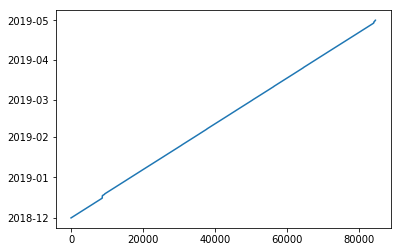

In [479]:
plt.plot(np.arange(len(f.df)),f.df.index)

### 1- fasorial.remove_dup()

In [595]:
def check_dup(df):
    c=0
    c1=0
    for i in df.index:
        if c == i :
            c1 +=1
        c=i
    return c1
    

In [596]:
def check_dup_2(df):
    return df.index.duplicated(keep='first').sum()

In [597]:
print(check_dup(f.df), check_dup_2(f.df))

70449 70449


In [598]:
print( len(f.df) - len(f.remove_dup(df = f.df.copy())))

70449


In [681]:
f.remove_dup()

,ponto_medicao,serial,RTC,RTP,KE,IA,IB,IC,AIA,AIB,...,DH,FREQ,SEQ,DEMAND_C1,DEMAND_C2,DEMAND_C3,TOT_C1,TOT_C2,TOT_C3,DEM_INTERVAL
data,,,,,,,,,,,,,,,,,,,,,
2018-12-01 00:00:05,BT2A400029491,9445060,1/1,1/1,1/1,"1,63","4,7","5,19",330,76,...,0,60,132,36,31,0,625810,409045,16,15
2018-12-01 00:15:04,BT2A400029491,9445060,1/1,1/1,1/1,"1,6","4,72","3,78",327,75,...,0,60,132,36,29,0,625846,409074,16,15
2018-12-01 00:30:03,BT2A400029491,9445060,1/1,1/1,1/1,"1,58","4,71","6,97",329,74,...,0,60,132,37,31,0,625883,409105,16,15
2018-12-01 00:45:04,BT2A400029491,9445060,1/1,1/1,1/1,"1,61","5,78","5,74",326,73,...,0,60,132,34,28,0,625917,409133,16,15
2018-12-01 01:00:08,BT2A400029491,9445060,1/1,1/1,1/1,"1,66","5,75","5,81",324,73,...,0,60,132,35,30,0,625952,409163,16,15
2018-12-01 01:15:01,BT2A400029491,9445060,1/1,1/1,1/1,"1,66","2,98","5,25",326,74,...,0,60,132,36,31,0,625988,409194,16,15
2018-12-01 01:30:02,BT2A400029491,9445060,1/1,1/1,1/1,"1,62",3,"5,17",325,73,...,0,60,132,33,28,0,626021,409222,16,15
2018-12-01 01:45:05,BT2A400029491,9445060,1/1,1/1,1/1,"1,64","3,01","7,01",331,73,...,0,60,132,32,27,0,626053,409249,16,15
2018-12-01 02:00:04,BT2A400029491,9445060,1/1,1/1,1/1,"1,66","4,61","7,15",325,73,...,0,60,132,32,28,0,626085,409277,16,15


## l_______________________________________________________________________

### 2-  fasorial.drop_hollydays()

# ????

## l_______________________________________________________________________

### 3-  fasorial.split_months
##### Pega 30 dias antes da data de leitura, exclusive a última

In [537]:
months = {'Janeiro':1, 'Fevereiro':2, 'Março':3, 'Abril':4, 'Dezembro':12}
months2 = dict([[v,k] for k,v in months.items()])

In [519]:
ddays = default_ddays()
ddays

{12: Timestamp('2018-12-31 00:00:00'),
 1: Timestamp('2019-01-31 00:00:00'),
 2: Timestamp('2019-02-28 00:00:00'),
 3: Timestamp('2019-03-31 00:00:00'),
 4: Timestamp('2019-04-30 00:00:00')}

In [532]:
print(
    len(f.df[ddays[12] - pd.Timedelta(days=30):ddays[12]]),
    len(f.df[ddays[1] - pd.Timedelta(days=30):ddays[1]]),
    len(f.df[ddays[2] - pd.Timedelta(days=30):ddays[2]]),
    len(f.df[ddays[3] - pd.Timedelta(days=30):ddays[3]]),
    len(f.df[ddays[4] - pd.Timedelta(days=30):ddays[4]])
)

16025 17208 17148 17118 16704


In [671]:
f.split_months(ddays=ddays)
for y in f.months:
    for m in f.months[y]:
        print(len(f.months[y][m].df))

16025
17208
17148
17118
16704


In [682]:
for y in f.months:
    for m in f.months[y]:
        print(pd.Timestamp(f.months[y][m].df.index[0]).weekday())

5
1
1
4
6


In [555]:
for y in f.months:
    for m in f.months[y]:
        print(months2[m])
        print(f.months[y][m].df.resample('D').count().resample('M').count().iloc[:,0])

Dezembro
data
2018-12-31    30
Freq: M, Name: ponto_medicao, dtype: int64
Janeiro
data
2019-01-31    30
Freq: M, Name: ponto_medicao, dtype: int64
Fevereiro
data
2019-01-31     3
2019-02-28    27
Freq: M, Name: ponto_medicao, dtype: int64
Março
data
2019-03-31    30
Freq: M, Name: ponto_medicao, dtype: int64
Abril
data
2019-03-31     1
2019-04-30    29
Freq: M, Name: ponto_medicao, dtype: int64


## l_______________________________________________________________________

### 3-  fasorial.proc_fasorial()

In [824]:
import mainlib

reload(mainlib)

from mainlib import fasorial

#provisório
exemplo = 'BT2A400029491'
arquivo = dfiles_fas[exemplo][0]
f = fasorial()
f.read_fasorial(os.path.join(PATH_FAS, arquivo), sep=';', dtype= None)
f.remove_dup()
f.split_months(ddays = default_ddays())

{2018: {12: <mainlib.fasorial at 0x7fb974d72c18>},
 2019: {1: <mainlib.fasorial at 0x7fb974c37e80>,
  2: <mainlib.fasorial at 0x7fb974c36358>,
  3: <mainlib.fasorial at 0x7fb974c38fd0>,
  4: <mainlib.fasorial at 0x7fb974c3cc18>}}

In [825]:
jan = copy.deepcopy(f.months[2019][1])

daterange(jan.df)

(Timestamp('2019-01-01 00:00:03'),
 Timestamp('2019-01-30 23:45:04'),
 Timedelta('29 days 23:45:01'))

In [826]:
30*24*4

2880

In [827]:
jan.df.shape

(17208, 39)

In [699]:
jan.df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17208 entries, 2019-01-01 00:00:03 to 2019-01-30 23:45:04
Data columns (total 39 columns):
ponto_medicao    17208 non-null object
serial           17208 non-null int64
RTC              17208 non-null object
RTP              17208 non-null object
KE               17208 non-null object
IA               17208 non-null object
IB               17208 non-null object
IC               17208 non-null object
AIA              17208 non-null int64
AIB              17208 non-null int64
AIC              17208 non-null int64
VA               17208 non-null object
VB               17208 non-null object
VC               17208 non-null object
AVA              17208 non-null int64
AVB              17208 non-null int64
AVC              17208 non-null int64
VAB              17208 non-null object
VBC              17208 non-null object
VAC              17208 non-null object
AVAB             17208 non-null int64
AVBC             17208 non-null int64
AVAC   

In [828]:
jan.proc_fasorial()

,ponto_medicao,serial,IA,IB,IC,AIA,AIB,AIC,VA,VB,...,VAC,AVAB,AVBC,AVAC,PA,PB,PC,FPA,FPB,FPC
data,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,BT2A400029491,9445060.0,1.71,0.07,3.69,324.0,68.0,193.0,120.0,124.0,...,208.0,0.0,0.0,0.0,165.0,5.0,306.0,80.0,61.0,68.0
2019-01-01 00:15:00,BT2A400029491,9445060.0,1.58,0.06,5.26,329.0,77.0,191.0,120.0,124.0,...,210.0,0.0,0.0,0.0,161.0,5.0,422.0,85.0,72.0,65.0
2019-01-01 00:30:00,BT2A400029491,9445060.0,1.54,0.00,3.20,324.0,120.0,191.0,119.0,125.0,...,208.0,0.0,0.0,0.0,148.0,0.0,257.0,80.0,100.0,65.0
2019-01-01 00:45:00,BT2A400029491,9445060.0,1.71,0.06,4.65,324.0,72.0,193.0,119.0,125.0,...,207.0,0.0,0.0,0.0,164.0,5.0,381.0,80.0,66.0,67.0
2019-01-01 01:00:00,BT2A400029491,9445060.0,1.55,0.00,4.58,325.0,120.0,190.0,118.0,125.0,...,206.0,0.0,0.0,0.0,149.0,0.0,360.0,81.0,100.0,64.0
2019-01-01 01:15:00,BT2A400029491,9445060.0,1.66,0.06,6.53,326.0,73.0,190.0,120.0,123.0,...,208.0,0.0,0.0,0.0,164.0,5.0,508.0,82.0,68.0,64.0
2019-01-01 01:30:00,BT2A400029491,9445060.0,1.68,0.05,6.59,325.0,209.0,190.0,120.0,124.0,...,207.0,0.0,0.0,0.0,163.0,0.0,511.0,81.0,0.0,64.0
2019-01-01 01:45:00,BT2A400029491,9445060.0,1.70,0.05,3.15,324.0,75.0,193.0,119.0,121.0,...,208.0,0.0,0.0,0.0,162.0,4.0,260.0,80.0,70.0,67.0
2019-01-01 02:00:00,BT2A400029491,9445060.0,1.64,0.05,3.26,323.0,78.0,192.0,118.0,122.0,...,207.0,0.0,0.0,0.0,154.0,4.0,266.0,79.0,74.0,66.0


In [833]:
jan.df.shape

(2880, 35)

In [831]:
assert jan.df.shape[0] == 30*24*4

In [702]:
jan.outputs

{'name': 'noname',
 'empty_values': {'virg_to_ponto': ({'IA': 0,
    'IB': 0,
    'IC': 0,
    'AIA': 0,
    'AIB': 0,
    'AIC': 0,
    'VA': 0,
    'VB': 0,
    'VC': 0,
    'AVA': 0,
    'AVB': 0,
    'AVC': 0,
    'VAB': 0,
    'VBC': 0,
    'VAC': 0,
    'AVAB': 0,
    'AVBC': 0,
    'AVAC': 0,
    'PA': 0,
    'PB': 0,
    'PC': 0,
    'FPA': 0,
    'FPB': 0,
    'FPC': 0},
   {'IA': 0,
    'IB': 0,
    'IC': 0,
    'AIA': 0,
    'AIB': 0,
    'AIC': 0,
    'VA': 0,
    'VB': 0,
    'VC': 0,
    'AVA': 0,
    'AVB': 0,
    'AVC': 0,
    'VAB': 0,
    'VBC': 0,
    'VAC': 0,
    'AVAB': 0,
    'AVBC': 0,
    'AVAC': 0,
    'PA': 0,
    'PB': 0,
    'PC': 0,
    'FPA': 0,
    'FPB': 0,
    'FPC': 0})},
 'shapes': {'dropcols': [(17208, 39), (17208, 26)],
  'reorg': [(17208, 26), (2880, 26)]},
 'missing_rows': 12}

## l_______________________________________________________________________

### 3-  fasorial.feat_eng_fasorial()

In [832]:
jan.feat_eng_fasorial()

In [703]:
jan.feat_eng_fasorial??

Signature: jan.feat_eng_fasorial(df=None)
Docstring: <no docstring>
Source:   
    def feat_eng_fasorial(self, df=None):
        if type(df) != pd.core.frame.DataFrame:
            df = self.df
        if df.shape[0] == 0 or df.shape[1] == 0:
            print('Dataframe Vazio (feat_eng_fasorial)')
        self.tension_angles()
        self.min_of_three(['VA', 'VB', 'VC'], 'minV')
        self.min_of_three(['IA', 'IB', 'IC'], 'minA')
        self.min_of_three(['PA', 'PB', 'PC'], 'minP')
        self.min_of_three(['VAB', 'VBC', 'VAC'], 'minVF')
        self.angle_check()
        self.call_pot()
File:      ~/data/code/rotcetedf/topy/mainlib.py
Type:      method


#### tension_angles

In [714]:
jan.tension_angles??

Signature: jan.tension_angles(df=None)
Docstring: <no docstring>
Source:   
    def tension_angles(self, df = None):
        if type(df) != pd.core.frame.DataFrame:
            df = self.df
        df['aab'] = abs(df['AVA'] - df['AVB'])
        df['abc'] = abs(df['AVB'] - df['AVC'])
        df['aac'] = abs(df['AVA'] - df['AVC'])
            
        
        self.df = df
        return self.df
File:      ~/data/code/rotcetedf/topy/mainlib.py
Type:      method


In [716]:
jan.df[['AVA','AVB', 'aab']]

,AVA,AVB,aab
data,,,
2019-01-01 00:00:03,0,120,120
2019-01-01 00:00:03,0,120,120
2019-01-01 00:00:03,0,120,120
2019-01-01 00:00:03,0,120,120
2019-01-01 00:00:03,0,120,120
2019-01-01 00:00:03,0,120,120
2019-01-01 00:15:04,0,120,120
2019-01-01 00:15:04,0,120,120
2019-01-01 00:15:04,0,120,120


In [717]:
jan.df[['AVA','AVC', 'aac']]

,AVA,AVC,aac
data,,,
2019-01-01 00:00:03,0,240,240
2019-01-01 00:00:03,0,240,240
2019-01-01 00:00:03,0,240,240
2019-01-01 00:00:03,0,240,240
2019-01-01 00:00:03,0,240,240
2019-01-01 00:00:03,0,240,240
2019-01-01 00:15:04,0,240,240
2019-01-01 00:15:04,0,240,240
2019-01-01 00:15:04,0,240,240


In [718]:
jan.df[['AVB','AVC', 'abc']]

,AVB,AVC,abc
data,,,
2019-01-01 00:00:03,120,240,120
2019-01-01 00:00:03,120,240,120
2019-01-01 00:00:03,120,240,120
2019-01-01 00:00:03,120,240,120
2019-01-01 00:00:03,120,240,120
2019-01-01 00:00:03,120,240,120
2019-01-01 00:15:04,120,240,120
2019-01-01 00:15:04,120,240,120
2019-01-01 00:15:04,120,240,120


#### min_of_three

In [721]:
jan.feat_eng_fasorial??

Signature: jan.feat_eng_fasorial(df=None)
Docstring: <no docstring>
Source:   
    def feat_eng_fasorial(self, df=None):
        if type(df) != pd.core.frame.DataFrame:
            df = self.df
        if df.shape[0] == 0 or df.shape[1] == 0:
            print('Dataframe Vazio (feat_eng_fasorial)')
        self.tension_angles()
        self.min_of_three(['VA', 'VB', 'VC'], 'minV')
        self.min_of_three(['IA', 'IB', 'IC'], 'minA')
        self.min_of_three(['PA', 'PB', 'PC'], 'minP')
        self.min_of_three(['VAB', 'VBC', 'VAC'], 'minVF')
        self.angle_check()
        self.call_pot()
File:      ~/data/code/rotcetedf/topy/mainlib.py
Type:      method


In [719]:
jan.df[['VA', 'VB', 'VC', 'minV']]

,VA,VB,VC,minV
data,,,,
2019-01-01 00:00:03,120.0,124.0,121.0,120.0
2019-01-01 00:00:03,120.0,124.0,121.0,120.0
2019-01-01 00:00:03,120.0,124.0,121.0,120.0
2019-01-01 00:00:03,120.0,124.0,121.0,120.0
2019-01-01 00:00:03,120.0,124.0,121.0,120.0
2019-01-01 00:00:03,120.0,124.0,121.0,120.0
2019-01-01 00:15:04,120.0,124.0,123.0,120.0
2019-01-01 00:15:04,120.0,124.0,123.0,120.0
2019-01-01 00:15:04,120.0,124.0,123.0,120.0


In [723]:
jan.df[['IA', 'IB', 'IC','minA']]

,IA,IB,IC,minA
data,,,,
2019-01-01 00:00:03,1.71,0.07,3.69,0.07
2019-01-01 00:00:03,1.71,0.07,3.69,0.07
2019-01-01 00:00:03,1.71,0.07,3.69,0.07
2019-01-01 00:00:03,1.71,0.07,3.69,0.07
2019-01-01 00:00:03,1.71,0.07,3.69,0.07
2019-01-01 00:00:03,1.71,0.07,3.69,0.07
2019-01-01 00:15:04,1.58,0.06,5.26,0.06
2019-01-01 00:15:04,1.58,0.06,5.26,0.06
2019-01-01 00:15:04,1.58,0.06,5.26,0.06


In [726]:
jan.df[['PA', 'PB', 'PC','minP']]

,PA,PB,PC,minP
data,,,,
2019-01-01 00:00:03,165.0,5.0,306.0,5.0
2019-01-01 00:00:03,165.0,5.0,306.0,5.0
2019-01-01 00:00:03,165.0,5.0,306.0,5.0
2019-01-01 00:00:03,165.0,5.0,306.0,5.0
2019-01-01 00:00:03,165.0,5.0,306.0,5.0
2019-01-01 00:00:03,165.0,5.0,306.0,5.0
2019-01-01 00:15:04,161.0,5.0,422.0,5.0
2019-01-01 00:15:04,161.0,5.0,422.0,5.0
2019-01-01 00:15:04,161.0,5.0,422.0,5.0


#### angle_check

In [727]:
jan.angle_check??

Signature: jan.angle_check(df=None, angle_cols=['aab', 'abc', 'aac'])
Docstring: <no docstring>
Source:   
    def angle_check(self, df=None, angle_cols = ['aab', 'abc', 'aac']):
        #True -> perda
        if type(df) != pd.core.frame.DataFrame:
            df = self.df   
            
        good_angles = np.concatenate( (np.arange(115, 126), np.arange(235, 246), np.array([0])), axis = 0)
        ac0=np.asarray(~df[angle_cols[0]].isin(good_angles)).reshape(-1,1)
        ac1=np.asarray(~df[angle_cols[1]].isin(good_angles)).reshape(-1,1)
        ac2=np.asarray(~df[angle_cols[2]].isin(good_angles)).reshape(-1,1)
        ac=np.concatenate( (ac0,ac1,ac2), axis=1)
        df['angcheck'] = np.any(ac, axis = 1)
        self.df = df
        return self.df
File:      ~/data/code/rotcetedf/topy/mainlib.py
Type:      method


In [735]:
jan.df[['aab','abc','aac','angcheck']]

,aab,abc,aac,angcheck
data,,,,


In [735]:
jan.df[['aab','abc','aac','angcheck']][jan.df['angcheck']==True]

,aab,abc,aac,angcheck
data,,,,


#### call_pot

In [736]:
jan.call_pot??

Signature: jan.call_pot()
Docstring: <no docstring>
Source:   
    def call_pot(self):
        self.df['PotNeg'] =self.df.loc[:,'IA':'FPC'].apply(self.potNegativa, raw=True, axis=1)
        return self.df.loc[:,'IA':'FPC'].apply(self.potNegativa, raw=True, axis=1)
File:      ~/data/code/rotcetedf/topy/mainlib.py
Type:      method


In [738]:
jan.df.columns

Index(['ponto_medicao', 'serial', 'IA', 'IB', 'IC', 'AIA', 'AIB', 'AIC', 'VA',
       'VB', 'VC', 'AVA', 'AVB', 'AVC', 'VAB', 'VBC', 'VAC', 'AVAB', 'AVBC',
       'AVAC', 'PA', 'PB', 'PC', 'FPA', 'FPB', 'FPC', 'aab', 'abc', 'aac',
       'minV', 'minA', 'minP', 'minVF', 'angcheck', 'PotNeg'],
      dtype='object')

In [737]:
jan.potNegativa??

Signature: jan.potNegativa(vals, customerType='BT', nElem=3)
Source:   
    def potNegativa(self, vals, customerType="BT", nElem = 3, ):
        '''
            True-> perda
        '''
        iA, iB, iC, aiA, aiB, aiC, vA, vB, vC, avA, avB, avC,VAB, VBC, VAC, AVAB, AVBC, AVAC, pA, pB, pC, fpA, fpB, fpC = vals[0], vals[1],vals[2],vals[3],vals[4],vals[5], \
        vals[6], vals[7],vals[8],vals[9],vals[10],vals[11],vals[12], vals[13],vals[14],vals[15],vals[16],vals[17],vals[18], vals[19],vals[20],vals[21],vals[22],vals[23]
        
        result =False
        if (customerType == "MT"):
            #considera as potências no secundário
            maxPotNegMT = -8 #Watts
            minFPPotNeg = abs(-0.2) 
            if ((pA <= maxPotNegMT and abs(fpA) > minFPPotNeg) or (pB <= maxPotNegMT and abs(fpB) > minFPPotNeg)) or ((nElem == 3 and (pC <= maxPotNegMT and abs(fpC) > minFPPotNeg)) or (nElem == 2 and (pC <= maxPotNegMT and abs(fpC) > minFPPotNeg) and (aiC < 30 or aiC > 210))):
   

### Summarize
##### <li> day_check <li> quantity_check <li> day_check_bool <li> quantity_check_bool <li> ult_corrente_zero <li> sunlight <li> cut_hours

In [743]:
df = copy.deepcopy(jan.df)

##### day_check
##### <li> Dúvida. Atualmente ativa com apenas uma leitura no dia. Isso está certo?

In [754]:
jan.day_check??

Signature: jan.day_check(col, df=None, threshold=0)
Docstring: <no docstring>
Source:   
    def day_check(self,col, df = None, threshold=0):
        if type(df) != pd.core.frame.DataFrame:
            df = self.df
        ndays = df[df[col]<threshold][col].resample('D').min().count()
        return ndays
File:      ~/data/code/rotcetedf/topy/mainlib.py
Type:      method


In [761]:
df[df['minV']<0.0001]['minV'].resample('D').min().count()

2

##### quantity_check

In [739]:
jan.quantity_check??

Signature: jan.quantity_check(col, df=None, threshold=0)
Docstring: <no docstring>
Source:   
    def quantity_check(self, col, df = None, threshold = 0):
        if type(df) != pd.core.frame.DataFrame:
            df = self.df        
        n = df[df[col] < threshold][col].count()*15
        return n
File:      ~/data/code/rotcetedf/topy/mainlib.py
Type:      method


In [749]:
jan.quantity_check('minV',threshold=0.0001)

720

In [753]:
df[df['minV']<0.0001]['minV'].count()

48

day_check_bool

In [766]:
jan.day_check_bool??

Signature: jan.day_check_bool(df=None, col='angcheck')
Docstring: <no docstring>
Source:   
    def day_check_bool(self, df = None, col='angcheck'):
        if type(df) != pd.core.frame.DataFrame:
            df = self.df
        return df[col].resample('D').apply(lambda x: (np.asarray(x)).any()).sum()
File:      ~/data/code/rotcetedf/topy/mainlib.py
Type:      method


In [812]:
jan.df.iloc[-600:]['angcheck'] = True

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [814]:
jan.day_check_bool(jan.df.iloc[-600:])

2

In [815]:
daterange(jan.df.iloc[-600:])

(Timestamp('2019-01-29 23:00:04'),
 Timestamp('2019-01-30 23:45:04'),
 Timedelta('1 days 00:45:00'))

quantity_check_bool

In [767]:
jan.quantity_check_bool??

Signature: jan.quantity_check_bool(df=None, col='angcheck')
Docstring: <no docstring>
Source:   
    def quantity_check_bool(self, df = None, col='angcheck'):
        if type(df) != pd.core.frame.DataFrame:
            df = self.df
        return (df[col]).sum()*15
File:      ~/data/code/rotcetedf/topy/mainlib.py
Type:      method


In [771]:
df[['aab','abc','aac']]

,aab,abc,aac
data,,,
2019-01-01 00:00:03,120,120,240
2019-01-01 00:00:03,120,120,240
2019-01-01 00:00:03,120,120,240
2019-01-01 00:00:03,120,120,240
2019-01-01 00:00:03,120,120,240
2019-01-01 00:00:03,120,120,240
2019-01-01 00:15:04,120,120,240
2019-01-01 00:15:04,120,120,240
2019-01-01 00:15:04,120,120,240


In [770]:
df['angcheck']

data
2019-01-01 00:00:03    False
2019-01-01 00:00:03    False
2019-01-01 00:00:03    False
2019-01-01 00:00:03    False
2019-01-01 00:00:03    False
2019-01-01 00:00:03    False
2019-01-01 00:15:04    False
2019-01-01 00:15:04    False
2019-01-01 00:15:04    False
2019-01-01 00:15:04    False
2019-01-01 00:15:04    False
2019-01-01 00:15:04    False
2019-01-01 00:30:05    False
2019-01-01 00:30:05    False
2019-01-01 00:30:05    False
2019-01-01 00:30:05    False
2019-01-01 00:30:05    False
2019-01-01 00:30:05    False
2019-01-01 00:45:04    False
2019-01-01 00:45:04    False
2019-01-01 00:45:04    False
2019-01-01 00:45:04    False
2019-01-01 00:45:04    False
2019-01-01 00:45:04    False
2019-01-01 01:00:02    False
2019-01-01 01:00:02    False
2019-01-01 01:00:02    False
2019-01-01 01:00:02    False
2019-01-01 01:00:02    False
2019-01-01 01:00:02    False
                       ...  
2019-01-30 22:45:04    False
2019-01-30 22:45:04    False
2019-01-30 22:45:04    False
2019-01-3

cut_hours

In [834]:
jan.cut_hours??

Signature: jan.cut_hours(horarios, df=None, inplace=False)
Source:   
    def cut_hours(self, horarios, df =None, inplace = False):
        """
        Return only the rows belonging to given period.
        inputs:
            hours:list with functioning hours of start and end, with the six following values:
                    initial_hour_working_days
                    final_hour_working_days
                    initial_hour_saturday
                    final_hour_saturday
                    initial_hour_sunday
                    final_hour_sunday
        output:
            a dataframe with the rows belonging to period.
        """
        if type(df) != pd.core.frame.DataFrame:
            df = self.df
        df2 = pd.concat( (
        df[df.index.weekday.isin(range(1,5))].between_time(horarios[0], horarios[1]), 
        df[df.index.weekday.isin([5])].between_time(horarios[2], horarios[3]), 
        df[df.index.weekday.isin([6])].between_time(horarios[4], horarios[5]) 
      

In [835]:
hours

['6:00', '18:00', '6:00', '18:00', '0:00', '0:00', '0:00', '0:00']

In [839]:
hours2 = ['6:00', '7:00', '6:00', '7:00', '6:00', '7:00', '6:00', '7:00']

In [837]:
daterange(jan.df)

(Timestamp('2019-01-01 00:00:00', freq='15T'),
 Timestamp('2019-01-30 23:45:00', freq='15T'),
 Timedelta('29 days 23:45:00'))

In [842]:
jan.cut_hours(hours2)

,ponto_medicao,serial,IA,IB,IC,AIA,AIB,AIC,VA,VB,...,FPC,aab,abc,aac,minV,minA,minP,minVF,angcheck,PotNeg
data,,,,,,,,,,,,,,,,,,,,,
2019-01-01 06:00:00,BT2A400029491,9445060.0,2.94,0.00,2.51,333.0,120.0,210.0,119.0,122.0,...,86.0,120.0,120.0,240.0,119.0,0.00,0.0,208.0,False,False
2019-01-01 06:15:00,BT2A400029491,9445060.0,2.92,0.08,5.85,332.0,65.0,194.0,119.0,122.0,...,69.0,120.0,120.0,240.0,119.0,0.08,5.0,208.0,False,False
2019-01-01 06:30:00,BT2A400029491,9445060.0,3.42,0.06,5.82,330.0,209.0,194.0,119.0,123.0,...,69.0,120.0,120.0,240.0,119.0,0.06,0.0,209.0,False,False
2019-01-01 06:45:00,BT2A400029491,9445060.0,3.02,0.07,5.90,332.0,74.0,195.0,118.0,122.0,...,70.0,120.0,120.0,240.0,118.0,0.07,5.0,207.0,False,False
2019-01-01 07:00:00,BT2A400029491,9445060.0,2.92,0.06,3.87,332.0,77.0,198.0,118.0,122.0,...,74.0,120.0,120.0,240.0,118.0,0.06,5.0,207.0,False,False
2019-01-02 06:00:00,BT2A400029491,9445060.0,2.85,0.06,7.07,331.0,209.0,191.0,114.0,122.0,...,65.0,120.0,120.0,240.0,114.0,0.06,0.0,204.0,False,False
2019-01-02 06:15:00,BT2A400029491,9445060.0,2.92,0.07,5.21,329.0,73.0,198.0,118.0,122.0,...,74.0,120.0,120.0,240.0,118.0,0.07,5.0,207.0,False,False
2019-01-02 06:30:00,BT2A400029491,9445060.0,2.88,0.09,5.22,331.0,68.0,198.0,120.0,121.0,...,74.0,120.0,120.0,240.0,120.0,0.09,6.0,208.0,False,False
2019-01-02 06:45:00,BT2A400029491,9445060.0,2.92,0.07,7.03,330.0,73.0,196.0,120.0,124.0,...,71.0,120.0,120.0,240.0,120.0,0.07,5.0,209.0,False,False


sun_light

In [843]:
jan.sunlight??

Signature: jan.sunlight(df=None)
Docstring: <no docstring>
Source:   
    def sunlight(self, df = None):
        if type(df) != pd.core.frame.DataFrame:
            df = self.df
        self.df = df.between_time('6:00','18:00')
        return self.df
File:      ~/data/code/rotcetedf/topy/mainlib.py
Type:      method


In [845]:
jan.sunlight()['2019-01-01']

,ponto_medicao,serial,IA,IB,IC,AIA,AIB,AIC,VA,VB,...,FPC,aab,abc,aac,minV,minA,minP,minVF,angcheck,PotNeg
data,,,,,,,,,,,,,,,,,,,,,
2019-01-01 06:00:00,BT2A400029491,9445060.0,2.94,0.00,2.51,333.0,120.0,210.0,119.0,122.0,...,86.0,120.0,120.0,240.0,119.0,0.00,0.0,208.0,False,False
2019-01-01 06:15:00,BT2A400029491,9445060.0,2.92,0.08,5.85,332.0,65.0,194.0,119.0,122.0,...,69.0,120.0,120.0,240.0,119.0,0.08,5.0,208.0,False,False
2019-01-01 06:30:00,BT2A400029491,9445060.0,3.42,0.06,5.82,330.0,209.0,194.0,119.0,123.0,...,69.0,120.0,120.0,240.0,119.0,0.06,0.0,209.0,False,False
2019-01-01 06:45:00,BT2A400029491,9445060.0,3.02,0.07,5.90,332.0,74.0,195.0,118.0,122.0,...,70.0,120.0,120.0,240.0,118.0,0.07,5.0,207.0,False,False
2019-01-01 07:00:00,BT2A400029491,9445060.0,2.92,0.06,3.87,332.0,77.0,198.0,118.0,122.0,...,74.0,120.0,120.0,240.0,118.0,0.06,5.0,207.0,False,False
2019-01-01 07:15:00,BT2A400029491,9445060.0,3.00,0.00,3.88,329.0,120.0,200.0,118.0,124.0,...,76.0,120.0,120.0,240.0,118.0,0.00,0.0,209.0,False,False
2019-01-01 07:30:00,BT2A400029491,9445060.0,3.01,0.06,7.17,331.0,69.0,193.0,120.0,124.0,...,67.0,120.0,120.0,240.0,120.0,0.06,4.0,209.0,False,False
2019-01-01 07:45:00,BT2A400029491,9445060.0,2.96,0.06,7.19,331.0,77.0,193.0,120.0,122.0,...,67.0,120.0,120.0,240.0,120.0,0.06,5.0,209.0,False,False
2019-01-01 08:00:00,BT2A400029491,9445060.0,3.02,0.07,7.20,332.0,78.0,195.0,120.0,121.0,...,70.0,120.0,120.0,240.0,120.0,0.07,6.0,208.0,False,False
